# Contents

[1 Preprocess](#preprocess)

[2 Define Three Phases](#three_phases)

[3 Local Movement](#local)

[4 Outflow](#out)

[5 Inflow](#in)

# 1 Processing PUMS data to Migration Flow  <a id = "preprocess"></a>

These codes read and preprocess the raw data (csv files) of 2017-2021 PUMS data into population flows

## Load packages

In [1]:
import glob
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import mapclassify
import copy
import os
from scipy.spatial import cKDTree
from shapely.geometry import Point,LineString
import us
import contextily as cx
from geopy.distance import geodesic as GD

plt.rcParams['figure.figsize'] = [15, 15]
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

table_path = "F:/PUMS/Tables/"
GIS_path = "F:/PUMS/GIS_data/"
intermediate_path = table_path + "intermediate_output/"

C:\Users\xiang11\.conda\envs\geo\lib\site-packages\mapclassify\classifiers.py:511: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _fisher_jenks_means(values, classes=5, sort=True):


## Combine separate 5-year PUMS (csv) files to a dataframe

The combined dataframe (df) is very large. Please refer to this [document ](https://usa.ipums.org/usa/resources/codebooks/DataDict1519.pdf) for the meanings of the columns.

In [2]:
# Getting a list of raw csv files starting with "psam_pu"
# These data are 2015-2019 5-year data downloaded from https://www.census.gov/programs-surveys/acs/microdata/access.html
f_ls = glob.glob(table_path+'raw_data/5_years/2015-2019/psam_pus*')

# test the list
df_ls=[]
for f in f_ls:
    print(f)
    df_ls.append(pd.read_csv(f))
    
df = pd.concat(df_ls)

F:/PUMS/Tables/raw_data/5_years/2015-2019\psam_pusa.csv


C:\Users\xiang11\AppData\Local\Temp\ipykernel_16544\2178602487.py:9: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ls.append(pd.read_csv(f))


F:/PUMS/Tables/raw_data/5_years/2015-2019\psam_pusb.csv


C:\Users\xiang11\AppData\Local\Temp\ipykernel_16544\2178602487.py:9: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ls.append(pd.read_csv(f))


F:/PUMS/Tables/raw_data/5_years/2015-2019\psam_pusc.csv


C:\Users\xiang11\AppData\Local\Temp\ipykernel_16544\2178602487.py:9: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ls.append(pd.read_csv(f))


F:/PUMS/Tables/raw_data/5_years/2015-2019\psam_pusd.csv


C:\Users\xiang11\AppData\Local\Temp\ipykernel_16544\2178602487.py:9: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ls.append(pd.read_csv(f))


In [4]:
puma = gpd.read_file(GIS_path+'GIS_data/ipums_puma_2010.shp')
migpuma = gpd.read_file(GIS_path+"GIS_data/ipums_migpuma_pwpuma_2010.shp")
puma['PUMA2'] = puma['STATEFIP'] + puma['PUMA']
# combine state code and MIGPUMA code
migpuma['MIGPUMA2'] = migpuma['STATEFIP'] + migpuma['MIGPUMA']
puma_p = gpd.read_file(GIS_path+"GIS_data/puma_p.shp")
migpuma_p = gpd.read_file(GIS_path+"GIS_data/migpuma_p.shp")

## Combine 
#### Delete NaN records and store the year of the records in a new column

In [12]:
df1 = df[~df['SERIALNO'].isna()]
df1['year'] = df1['SERIALNO'].astype(str).str[0:4]

In [13]:
df1.head()

RT       SERIALNO  DIVISION  SPORDER  PUMA  REGION  ST   ADJINC  PWGTP  \
0  P  2015000000067         6        1  2701       3   1  1080470      9   
1  P  2015000000067         6        2  2701       3   1  1080470      9   
2  P  2015000000067         6        3  2701       3   1  1080470     12   
3  P  2015000000067         6        4  2701       3   1  1080470     14   
4  P  2015000000160         6        1  1000       3   1  1080470     15   

   AGEP  CIT  CITWP  COW  DDRS  DEAR  DEYE  DOUT  DPHY  DRAT  DRATX  DREM  \
0    56    1    NaN  6.0   2.0     2     2   2.0   1.0   NaN    NaN   2.0   
1    61    1    NaN  NaN   2.0     2     2   2.0   2.0   NaN    NaN   2.0   
2     8    1    NaN  NaN   2.0     2     2   NaN   2.0   NaN    NaN   2.0   
3    61    1    NaN  1.0   2.0     2     2   2.0   2.0   NaN    2.0   2.0   
4    52    1    NaN  NaN   2.0     2     2   2.0   1.0   NaN    NaN   1.0   

   ENG  FER  GCL  GCM  GCR  HINS1  HINS2  HINS3  HINS4  HINS5  HINS6  HINS7  \
0  NaN  NaN  1.0  1.0  1.0      1      2      2      2      2      2      2   
1  NaN  NaN  1.0  NaN  2.0      1      2      2      2      2      2      2   
2  NaN  NaN  NaN  NaN  NaN      2      2      2      1      2      2      2   
3  NaN  NaN  2.0  NaN  NaN      2      2      2      2      2      2      2   
4  NaN  NaN  2.0  NaN  NaN      2      2      2      1      2      2      2   

      INTP  JWMNP  JWRIP  JWTRNS  LANX  MAR  MARHD  MARHM  MARHT  MARHW  \
0      0.0    5.0    1.0     1.0   2.0    1    2.0    2.0    1.0    2.0   
1  14000.0    NaN    NaN     NaN   2.0    1    2.0    2.0    1.0    2.0   
2      NaN    NaN    NaN     NaN   2.0    5    NaN    NaN    NaN    NaN   
3      0.0   20.0    1.0     1.0   2.0    3    2.0    2.0    1.0    2.0   
4      0.0    NaN    NaN     NaN   2.0    3    2.0    2.0    3.0    2.0   

   MARHYP  MIG  MIL  MLPA  MLPB  MLPCD  MLPE  MLPFG  MLPH  MLPI  MLPJ  MLPK  \
0  2002.0  1.0  4.0   NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN   NaN   
1  2002.0  1.0  4.0   NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN   NaN   
2     NaN  3.0  NaN   NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN   NaN   
3  1996.0  1.0  2.0   0.0   0.0    0.0   1.0    0.0   0.0   0.0   0.0   0.0   
4  1991.0  1.0  4.0   NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN   NaN   

   NWAB  NWAV  NWLA  NWLK  NWRE  OIP  PAP  RELSHIPP  RETP  SCH  SCHG  SCHL  \
0   3.0   5.0   3.0   3.0   3.0  0.0  0.0        20   0.0  1.0   NaN  14.0   
1   3.0   5.0   3.0   3.0   3.0  0.0  0.0        21   0.0  1.0   NaN  19.0   
2   NaN   NaN   NaN   NaN   NaN  NaN  NaN        30   NaN  2.0   5.0   5.0   
3   3.0   5.0   3.0   3.0   3.0  0.0  0.0        34   0.0  1.0   NaN  19.0   
4   2.0   5.0   2.0   3.0   2.0  0.0  0.0        20   0.0  1.0   NaN  11.0   

    SEMP  SEX    SSIP  SSP     WAGP  WKHP  WKL  WKW  WKWN  WRK  YOEP  ANC  \
0  650.0    1     0.0  0.0   2800.0   5.0  1.0  1.0   NaN  NaN   NaN    4   
1    0.0    2     0.0  0.0      0.0   NaN  3.0  NaN   NaN  NaN   NaN    4   
2    NaN    2     NaN  NaN      NaN   NaN  NaN  NaN   NaN  NaN   NaN    4   
3    0.0    1     0.0  0.0  35000.0  40.0  1.0  1.0   NaN  NaN   NaN    4   
4    0.0    2  8800.0  0.0      0.0   NaN  3.0  NaN   NaN  2.0   NaN    2   

   ANC1P  ANC2P  DECADE  DIS  DRIVESP  ESP  ESR  FOD1P  FOD2P  HICOV  HISP  \
0    999    999     NaN    1      1.0  NaN  1.0    NaN    NaN      1     1   
1    999    999     NaN    2      NaN  NaN  6.0    NaN    NaN      1     1   
2    999    999     NaN    2      NaN  NaN  NaN    NaN    NaN      1     1   
3    999    999     NaN    2      1.0  NaN  1.0    NaN    NaN      2     1   
4    924    920     NaN    1      NaN  NaN  6.0    NaN    NaN      1     1   

     INDP  JWAP  JWDP  LANP  MIGPUMA  MIGSP  MSP NAICSP  NATIVITY  NOP   OC  \
0  9160.0  90.0  50.0   NaN      NaN    NaN  1.0   8131         1  NaN  0.0   
1     NaN   NaN   NaN   NaN      NaN    NaN  1.0    NaN         1  NaN  0.0   
2     NaN   NaN   NaN   NaN   2700.0    1.0

### Read and preprocess PUMA-MIGPUMA conversion table

Find more information about PUMA, MIGPUMA and changes of PUMA areas from [here](https://engagedscholarship.csuohio.edu/cgi/viewcontent.cgi?article=1419&context=urban_facpub) and [here](https://www.census.gov/content/dam/Census/library/publications/2020/acs/acs_pums_handbook_2020_ch02.pdf).

In [14]:
# Read the PUMA <-> MIGPUMA crosswalk table
# We used 2010 data for Hurricane Harvey
trans = pd.read_csv(table_path+"Tables-selected/PUMA_MIGPUMA/2010/puma_migpuma1_pwpuma00_2010.csv")

Rename some column names.

In [18]:
# state/country of PUMA
trans = trans.rename(columns={"Place of Work State (PWSTATE2) or Migration State (MIGPLAC1)": "MIGSP"})
# Migpuma (county or group of counties)
trans = trans.rename(columns={"PWPUMA00 or MIGPUMA1": "MIGPUMA"})
# State of PUMA
trans = trans.rename(columns={"State of Residence (ST)": "ST"})

Format PUMA, State, MIGSP and MIGPUMA codes

In [19]:
# PUMA of current residence
trans['PUMA'] = trans['PUMA'].astype('int64').astype('str').str.rjust(5, "0")
# State of current residence
trans['ST'] = trans['ST'].astype('int16').astype('str').str.rjust(2, "0")
# State or country of migration PUMA
trans['MIGSP'] = trans['MIGSP'].astype('int64').astype('str').str.rjust(2, "0")
# Migration PUMA
trans['MIGPUMA'] = trans['MIGPUMA'].astype('int64').astype('str').str.rjust(5, "0")

Combine State/country with PUMA and MIGPUMA to a composite code

In [20]:
trans['PUMA2'] = trans['ST'] + trans['PUMA']
trans['MIGPUMA2'] = trans['MIGSP'] + trans['MIGPUMA']

In [21]:
trans

ST   PUMA MIGSP MIGPUMA    PUMA2 MIGPUMA2
0     01  00100    01   00190  0100100  0100190
1     01  00200    01   00290  0100200  0100290
2     01  00301    01   00290  0100301  0100290
3     01  00302    01   00290  0100302  0100290
4     01  00400    01   00400  0100400  0100400
...   ..    ...   ...     ...      ...      ...
2373  72  00902    72   00900  7200902  7200900
2374  72  01001    72   01001  7201001  7201001
2375  72  01002    72   01002  7201002  7201002
2376  72  01101    72   01101  7201101  7201101
2377  72  01102    72   01102  7201102  7201102

[2378 rows x 6 columns]

#### Remove records without migration data (non_migrants)

In [22]:
df2 = df1.dropna(subset=['MIGPUMA'])

Format MIGPUMA codes to be joined with the crosswalk table (trans).

In [23]:
# Format MIGPUMA codes
df2.loc[:,'MIGPUMA'] = df2['MIGPUMA'].astype('int64').astype('str').str.rjust(5, "0")
df2.loc[:,'PUMA'] = df2['PUMA'].astype('int64').astype('str').str.rjust(5, "0")
df2.loc[:,'MIGSP'] = df2['MIGSP'].astype('int64').astype('str').str.rjust(2, "0")
df2.loc[:,'ST'] = df2['ST'].astype('int64').astype('str').str.rjust(2, "0")

C:\Users\xiang11\AppData\Local\Temp\ipykernel_16544\1555462554.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[:,'MIGPUMA'] = df2['MIGPUMA'].astype('int64').astype('str').str.rjust(5, "0")
C:\Users\xiang11\AppData\Local\Temp\ipykernel_16544\1555462554.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[:,'PUMA'] = df2['PUMA'].astype('int64').astype('str').str.rjust(5, "0")
C:\Users\xiang11\AppData\Local\Temp\ipykernel_16544\1555462554.py:4: SettingWithCopyWarning: 
A value is trying to b

In [24]:
# Concatenate State and PUMA codes to unique codes for PUMA and MIGPUMA
# Origins are MIGPUMA, Destinations (current residence) are regular PUMA

df2.loc[:,'PUMA_D'] = df2['ST'] + df2['PUMA']
df2.loc[:,'MIGPUMA_O'] = df2['MIGSP'] + df2['MIGPUMA']

C:\Users\xiang11\AppData\Local\Temp\ipykernel_16544\1588349914.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[:,'PUMA_D'] = df2['ST'] + df2['PUMA']
C:\Users\xiang11\AppData\Local\Temp\ipykernel_16544\1588349914.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[:,'MIGPUMA_O'] = df2['MIGSP'] + df2['MIGPUMA']


In [26]:
# Merge PUMS data with the PUMA-MIGPUMA conversion table
# Rename column names
df2 = pd.merge(df2,trans,how='left',left_on='PUMA_D',right_on='PUMA2').drop(['ST_y','PUMA_y','MIGSP_y','MIGPUMA_y','PUMA2']
                                                                            ,axis=1).rename(columns={"MIGPUMA2": "MIGPUMA_D"})

In [27]:
df2.head()

RT       SERIALNO  DIVISION  SPORDER PUMA_x  REGION ST_x   ADJINC  PWGTP  \
0  P  2015000000067         6        3  02701       3   01  1080470     12   
1  P  2015000001052         6        1  02600       3   01  1080470      4   
2  P  2015000001890         6        1  01900       3   01  1080470      4   
3  P  2015000001898         6        2  00600       3   01  1080470     16   
4  P  2015000002757         6        1  02500       3   01  1080470      9   

   AGEP  CIT  CITWP  COW  DDRS  DEAR  DEYE  DOUT  DPHY  DRAT  DRATX  DREM  \
0     8    1    NaN  NaN   2.0     2     2   NaN   2.0   NaN    NaN   2.0   
1    47    1    NaN  1.0   2.0     2     2   2.0   2.0   NaN    2.0   2.0   
2    18    1    NaN  1.0   2.0     2     2   2.0   2.0   NaN    NaN   2.0   
3    21    1    NaN  1.0   2.0     2     2   2.0   2.0   NaN    NaN   2.0   
4    56    1    NaN  NaN   2.0     2     2   2.0   2.0   NaN    NaN   1.0   

   ENG  FER  GCL  GCM  GCR  HINS1  HINS2  HINS3  HINS4  HINS5  HINS6  HINS7  \
0  NaN  NaN  NaN  NaN  NaN      2      2      2      1      2      2      2   
1  NaN  NaN  2.0  NaN  NaN      2      2      2      1      2      2      2   
2  NaN  2.0  NaN  NaN  NaN      2      1      2      2      2      2      2   
3  NaN  NaN  NaN  NaN  NaN      1      2      2      2      2      2      2   
4  NaN  NaN  2.0  NaN  NaN      2      2      2      1      2      2      2   

   INTP  JWMNP  JWRIP  JWTRNS  LANX  MAR  MARHD  MARHM  MARHT  MARHW  MARHYP  \
0   NaN    NaN    NaN     NaN   2.0    5    NaN    NaN    NaN    NaN     NaN   
1   0.0    NaN    NaN     NaN   2.0    2    2.0    2.0    1.0    2.0  2006.0   
2   0.0    NaN    NaN     NaN   2.0    5    NaN    NaN    NaN    NaN     NaN   
3   0.0  130.0    1.0     1.0   2.0    5    NaN    NaN    NaN    NaN     NaN   
4   0.0    NaN    NaN     NaN   2.0    1    2.0    2.0    1.0    2.0  1996.0   

   MIG  MIL  MLPA  MLPB  MLPCD  MLPE  MLPFG  MLPH  MLPI  MLPJ  MLPK  NWAB  \
0  3.0  NaN   NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN   NaN   NaN   
1  3.0  3.0   NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN   NaN   2.0   
2  3.0  4.0   NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN   NaN   2.0   
3  3.0  4.0   NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN   NaN   3.0   
4  3.0  4.0   NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN   NaN   2.0   

   NWAV  NWLA  NWLK  NWRE  OIP  PAP  RELSHIPP  RETP  SCH  SCHG  SCHL  SEMP  \
0   NaN   NaN   NaN   NaN  NaN  NaN        30   NaN  2.0   5.0   5.0   NaN   
1   5.0   2.0   2.0   3.0  0.0  0.0        38   0.0  1.0   NaN  16.0   0.0   
2   5.0   2.0   2.0   3.0  0.0  0.0        38   0.0  2.0  15.0  16.0   0.0   
3   5.0   3.0   3.0   3.0  0.0  0.0        33   0.0  1.0   NaN  16.0   0.0   
4   5.0   2.0   2.0   3.0  0.0  0.0        20   0.0  1.0   NaN  11.0   0.0   

   SEX    SSIP  SSP     WAGP  WKHP  WKL  WKW  WKWN  WRK  YOEP  ANC  ANC1P  \
0    2     NaN  NaN      NaN   NaN  NaN  NaN   NaN  NaN   NaN    4    999   
1    1     0.0  0.0      0.0   NaN  2.0  NaN   NaN  2.0   NaN    1    902   
2    2     0.0  0.0  30000.0  12.0  1.0  1.0   NaN  2.0   NaN    1     26   
3    1     0.0  0.0  10000.0  40.0  1.0  1.0   NaN  1.0   NaN    1    924   
4    2  8200.0  0.0      0.0   NaN  3.0  NaN   NaN  2.0   NaN    1    902   

   ANC2P  DECADE  DIS  DRIVESP  ESP  ESR  FOD1P  FOD2P  HICOV  HISP    INDP  \
0    999     NaN    2      NaN  NaN  NaN    NaN    NaN      1     1     NaN   
1    999     NaN    2      NaN  NaN  6.0    NaN    NaN      1     1  3570.0   
2    999     NaN    2      NaN  NaN  6.0    NaN    NaN      1     1  8680.0   
3    999     NaN    2      1.0  NaN  1.0    NaN    NaN      1     1  5381.0   
4    999     NaN    1      NaN  NaN  6.0    NaN    NaN      1     1     NaN   

    JWAP  JWDP  LANP MIGPUMA_x MIGSP_x  MSP NAICSP  NATIVITY  NOP   OC  \
0    NaN   NaN   NaN     02700      01  NaN    NaN         1  NaN  0.0   
1    NaN   NaN   NaN     02400      01  3.0   336M         1  NaN  0.0   
2    NaN   NaN   NaN  

In [14]:
# Export data to a csv file
df2.to_csv(intermediate_path+'df15_19.csv')

# Preview 
df2.head()

RT       SERIALNO  DIVISION  SPORDER PUMA_x  REGION ST_x   ADJINC  PWGTP  \
0  P  2015000000067         6        3  02701       3   01  1080470     12   
1  P  2015000001052         6        1  02600       3   01  1080470      4   
2  P  2015000001890         6        1  01900       3   01  1080470      4   
3  P  2015000001898         6        2  00600       3   01  1080470     16   
4  P  2015000002757         6        1  02500       3   01  1080470      9   

   AGEP  CIT  CITWP  COW  DDRS  DEAR  DEYE  DOUT  DPHY  DRAT  DRATX  DREM  \
0     8    1    NaN  NaN   2.0     2     2   NaN   2.0   NaN    NaN   2.0   
1    47    1    NaN  1.0   2.0     2     2   2.0   2.0   NaN    2.0   2.0   
2    18    1    NaN  1.0   2.0     2     2   2.0   2.0   NaN    NaN   2.0   
3    21    1    NaN  1.0   2.0     2     2   2.0   2.0   NaN    NaN   2.0   
4    56    1    NaN  NaN   2.0     2     2   2.0   2.0   NaN    NaN   1.0   

   ENG  FER  GCL  GCM  GCR  HINS1  HINS2  HINS3  HINS4  HINS5  HINS6  HINS7  \
0  NaN  NaN  NaN  NaN  NaN      2      2      2      1      2      2      2   
1  NaN  NaN  2.0  NaN  NaN      2      2      2      1      2      2      2   
2  NaN  2.0  NaN  NaN  NaN      2      1      2      2      2      2      2   
3  NaN  NaN  NaN  NaN  NaN      1      2      2      2      2      2      2   
4  NaN  NaN  2.0  NaN  NaN      2      2      2      1      2      2      2   

   INTP  JWMNP  JWRIP  JWTRNS  LANX  MAR  MARHD  MARHM  MARHT  MARHW  MARHYP  \
0   NaN    NaN    NaN     NaN   2.0    5    NaN    NaN    NaN    NaN     NaN   
1   0.0    NaN    NaN     NaN   2.0    2    2.0    2.0    1.0    2.0  2006.0   
2   0.0    NaN    NaN     NaN   2.0    5    NaN    NaN    NaN    NaN     NaN   
3   0.0  130.0    1.0     1.0   2.0    5    NaN    NaN    NaN    NaN     NaN   
4   0.0    NaN    NaN     NaN   2.0    1    2.0    2.0    1.0    2.0  1996.0   

   MIG  MIL  MLPA  MLPB  MLPCD  MLPE  MLPFG  MLPH  MLPI  MLPJ  MLPK  NWAB  \
0  3.0  NaN   NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN   NaN   NaN   
1  3.0  3.0   NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN   NaN   2.0   
2  3.0  4.0   NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN   NaN   2.0   
3  3.0  4.0   NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN   NaN   3.0   
4  3.0  4.0   NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN   NaN   2.0   

   NWAV  NWLA  NWLK  NWRE  OIP  PAP  RELSHIPP  RETP  SCH  SCHG  SCHL  SEMP  \
0   NaN   NaN   NaN   NaN  NaN  NaN        30   NaN  2.0   5.0   5.0   NaN   
1   5.0   2.0   2.0   3.0  0.0  0.0        38   0.0  1.0   NaN  16.0   0.0   
2   5.0   2.0   2.0   3.0  0.0  0.0        38   0.0  2.0  15.0  16.0   0.0   
3   5.0   3.0   3.0   3.0  0.0  0.0        33   0.0  1.0   NaN  16.0   0.0   
4   5.0   2.0   2.0   3.0  0.0  0.0        20   0.0  1.0   NaN  11.0   0.0   

   SEX    SSIP  SSP     WAGP  WKHP  WKL  WKW  WKWN  WRK  YOEP  ANC  ANC1P  \
0    2     NaN  NaN      NaN   NaN  NaN  NaN   NaN  NaN   NaN    4    999   
1    1     0.0  0.0      0.0   NaN  2.0  NaN   NaN  2.0   NaN    1    902   
2    2     0.0  0.0  30000.0  12.0  1.0  1.0   NaN  2.0   NaN    1     26   
3    1     0.0  0.0  10000.0  40.0  1.0  1.0   NaN  1.0   NaN    1    924   
4    2  8200.0  0.0      0.0   NaN  3.0  NaN   NaN  2.0   NaN    1    902   

   ANC2P  DECADE  DIS  DRIVESP  ESP  ESR  FOD1P  FOD2P  HICOV  HISP    INDP  \
0    999     NaN    2      NaN  NaN  NaN    NaN    NaN      1     1     NaN   
1    999     NaN    2      NaN  NaN  6.0    NaN    NaN      1     1  3570.0   
2    999     NaN    2      NaN  NaN  6.0    NaN    NaN      1     1  8680.0   
3    999     NaN    2      1.0  NaN  1.0    NaN    NaN      1     1  5381.0   
4    999     NaN    1      NaN  NaN  6.0    NaN    NaN      1     1     NaN   

    JWAP  JWDP  LANP MIGPUMA_x MIGSP_x  MSP NAICSP  NATIVITY  NOP   OC  \
0    NaN   NaN   NaN     02700      01  NaN    NaN         1  NaN  0.0   
1    NaN   NaN   NaN     02400      01  3.0   336M         1  NaN  0.0   
2    NaN   NaN   NaN  

### Affected MIGPUMA
Here I only selected the migpuma located in affected area.
The datasource is from FEMA website.

In [30]:
df_af_migpuma = ["4803601","4803602","4803900","4804100","4804200","4804300","4804400","4804500","4804600",
                 "4804700","4804800","4804900","4805000","4805100","4805500","4805600","4806500","4806600"]

In [31]:
df_migpuma = migpuma[migpuma["MIGPUMA2"].isin(df_af_migpuma)].reset_index()

In [32]:
df_migpuma

index  GISMATCH STATEFIP  State MIGPLAC MIGPUMA PWSTATE PWPUMA  \
0     162   4803601       48  Texas     048   03601      48  03601   
1     163   4803602       48  Texas     048   03602      48  03602   
2     166   4803900       48  Texas     048   03900      48  03900   
3     168   4804100       48  Texas     048   04100      48  04100   
4     169   4804200       48  Texas     048   04200      48  04200   
5     170   4804300       48  Texas     048   04300      48  04300   
6     171   4804400       48  Texas     048   04400      48  04400   
7     172   4804500       48  Texas     048   04500      48  04500   
8     173   4804600       48  Texas     048   04600      48  04600   
9     174   4804700       48  Texas     048   04700      48  04700   
10    175   4804800       48  Texas     048   04800      48  04800   
11    176   4804900       48  Texas     048   04900      48  04900   
12    177   4805000       48  Texas     048   05000      48  05000   
13    178   4805100       48  Texas     048   05100      48  05100   
14    182   4805500       48  Texas     048   05500      48  05500   
15    183   4805600       48  Texas     048   05600      48  05600   
16    192   4806500       48  Texas     048   06500      48  06500   
17    193   4806600       48  Texas     048   06600      48  06600   

                                             geometry MIGPUMA2  
0   POLYGON ((24670.340 -670203.232, 24669.302 -67...  4803601  
1   POLYGON ((-21525.060 -731702.786, -21476.286 -...  4803602  
2   POLYGON ((94396.856 -678462.679, 94389.339 -67...  4803900  
3   POLYGON ((232476.646 -702703.794, 232480.922 -...  4804100  
4   MULTIPOLYGON (((207257.786 -838646.213, 207221...  4804200  
5   MULTIPOLYGON (((205598.187 -842851.827, 205589...  4804300  
6   MULTIPOLYGON (((108222.224 -890922.546, 108217...  4804400  
7   POLYGON ((80055.990 -798763.072, 80059.765 -79...  4804500  
8   MULTIPOLYGON (((103465.413 -872421.567, 103475...  4804600  
9   MULTIPOLYGON (((85798.152 -938049.531, 85815.3...  4804700  
10  MULTIPOLYGON (((76989.712 -944876.069, 76974.1...  4804800  
11  POLYGON ((55786.900 -883802.461, 55761.426 -88...  4804900  
12  MULTIPOLYGON (((-36522.591 -1015974.397, -3647...  4805000  
13  POLYGON ((-59915.558 -832301.069, -59471.873 -...  4805100  
14  MULTIPOLYGON (((-43828.716 -975790.558, -43729...  4805500  
15  MULTIPOLYGON (((-84073.845 -1051465.363, -8406...  4805600  
16  MULTIPOLYGON (((-116536.333 -1076812.446, -116...  4806500  
17  MULTIPOLYGON (((-125836.871 -1104782.328, -125...  4806600

<AxesSubplot: >

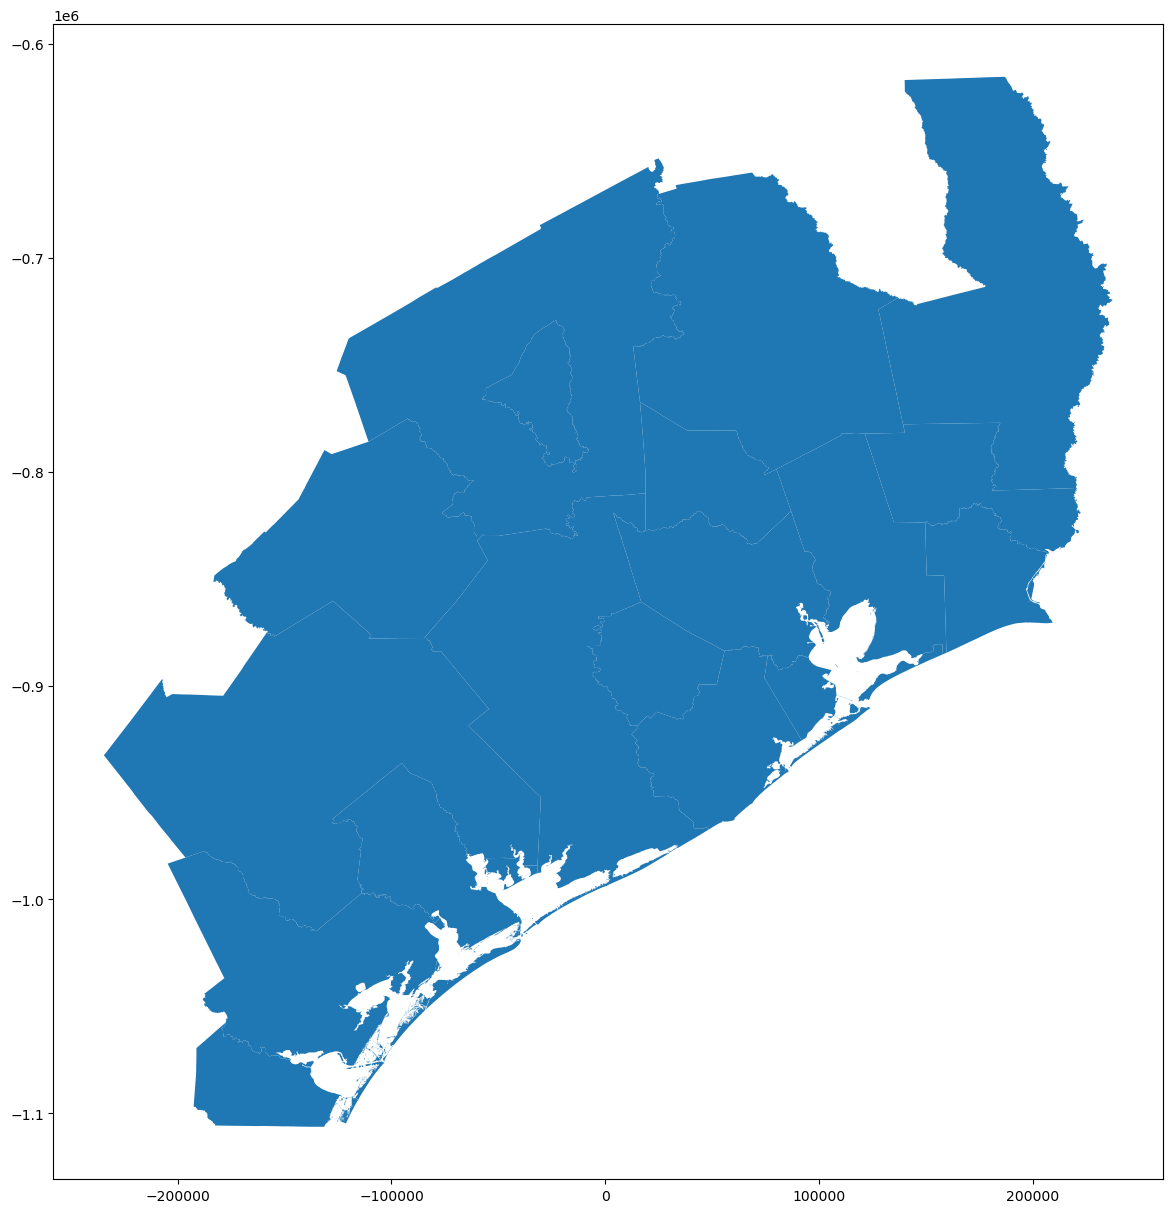

In [33]:
df_migpuma.plot()

### Calculate O-D pairs

In [34]:
df2.head()

RT       SERIALNO  DIVISION  SPORDER PUMA_x  REGION ST_x   ADJINC  PWGTP  \
0  P  2015000000067         6        3  02701       3   01  1080470     12   
1  P  2015000001052         6        1  02600       3   01  1080470      4   
2  P  2015000001890         6        1  01900       3   01  1080470      4   
3  P  2015000001898         6        2  00600       3   01  1080470     16   
4  P  2015000002757         6        1  02500       3   01  1080470      9   

   AGEP  CIT  CITWP  COW  DDRS  DEAR  DEYE  DOUT  DPHY  DRAT  DRATX  DREM  \
0     8    1    NaN  NaN   2.0     2     2   NaN   2.0   NaN    NaN   2.0   
1    47    1    NaN  1.0   2.0     2     2   2.0   2.0   NaN    2.0   2.0   
2    18    1    NaN  1.0   2.0     2     2   2.0   2.0   NaN    NaN   2.0   
3    21    1    NaN  1.0   2.0     2     2   2.0   2.0   NaN    NaN   2.0   
4    56    1    NaN  NaN   2.0     2     2   2.0   2.0   NaN    NaN   1.0   

   ENG  FER  GCL  GCM  GCR  HINS1  HINS2  HINS3  HINS4  HINS5  HINS6  HINS7  \
0  NaN  NaN  NaN  NaN  NaN      2      2      2      1      2      2      2   
1  NaN  NaN  2.0  NaN  NaN      2      2      2      1      2      2      2   
2  NaN  2.0  NaN  NaN  NaN      2      1      2      2      2      2      2   
3  NaN  NaN  NaN  NaN  NaN      1      2      2      2      2      2      2   
4  NaN  NaN  2.0  NaN  NaN      2      2      2      1      2      2      2   

   INTP  JWMNP  JWRIP  JWTRNS  LANX  MAR  MARHD  MARHM  MARHT  MARHW  MARHYP  \
0   NaN    NaN    NaN     NaN   2.0    5    NaN    NaN    NaN    NaN     NaN   
1   0.0    NaN    NaN     NaN   2.0    2    2.0    2.0    1.0    2.0  2006.0   
2   0.0    NaN    NaN     NaN   2.0    5    NaN    NaN    NaN    NaN     NaN   
3   0.0  130.0    1.0     1.0   2.0    5    NaN    NaN    NaN    NaN     NaN   
4   0.0    NaN    NaN     NaN   2.0    1    2.0    2.0    1.0    2.0  1996.0   

   MIG  MIL  MLPA  MLPB  MLPCD  MLPE  MLPFG  MLPH  MLPI  MLPJ  MLPK  NWAB  \
0  3.0  NaN   NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN   NaN   NaN   
1  3.0  3.0   NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN   NaN   2.0   
2  3.0  4.0   NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN   NaN   2.0   
3  3.0  4.0   NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN   NaN   3.0   
4  3.0  4.0   NaN   NaN    NaN   NaN    NaN   NaN   NaN   NaN   NaN   2.0   

   NWAV  NWLA  NWLK  NWRE  OIP  PAP  RELSHIPP  RETP  SCH  SCHG  SCHL  SEMP  \
0   NaN   NaN   NaN   NaN  NaN  NaN        30   NaN  2.0   5.0   5.0   NaN   
1   5.0   2.0   2.0   3.0  0.0  0.0        38   0.0  1.0   NaN  16.0   0.0   
2   5.0   2.0   2.0   3.0  0.0  0.0        38   0.0  2.0  15.0  16.0   0.0   
3   5.0   3.0   3.0   3.0  0.0  0.0        33   0.0  1.0   NaN  16.0   0.0   
4   5.0   2.0   2.0   3.0  0.0  0.0        20   0.0  1.0   NaN  11.0   0.0   

   SEX    SSIP  SSP     WAGP  WKHP  WKL  WKW  WKWN  WRK  YOEP  ANC  ANC1P  \
0    2     NaN  NaN      NaN   NaN  NaN  NaN   NaN  NaN   NaN    4    999   
1    1     0.0  0.0      0.0   NaN  2.0  NaN   NaN  2.0   NaN    1    902   
2    2     0.0  0.0  30000.0  12.0  1.0  1.0   NaN  2.0   NaN    1     26   
3    1     0.0  0.0  10000.0  40.0  1.0  1.0   NaN  1.0   NaN    1    924   
4    2  8200.0  0.0      0.0   NaN  3.0  NaN   NaN  2.0   NaN    1    902   

   ANC2P  DECADE  DIS  DRIVESP  ESP  ESR  FOD1P  FOD2P  HICOV  HISP    INDP  \
0    999     NaN    2      NaN  NaN  NaN    NaN    NaN      1     1     NaN   
1    999     NaN    2      NaN  NaN  6.0    NaN    NaN      1     1  3570.0   
2    999     NaN    2      NaN  NaN  6.0    NaN    NaN      1     1  8680.0   
3    999     NaN    2      1.0  NaN  1.0    NaN    NaN      1     1  5381.0   
4    999     NaN    1      NaN  NaN  6.0    NaN    NaN      1     1     NaN   

    JWAP  JWDP  LANP MIGPUMA_x MIGSP_x  MSP NAICSP  NATIVITY  NOP   OC  \
0    NaN   NaN   NaN     02700      01  NaN    NaN         1  NaN  0.0   
1    NaN   NaN   NaN     02400      01  3.0   336M         1  NaN  0.0   
2    NaN   NaN   NaN  

In [37]:
df_od = df2.groupby(["MIGPUMA_O","year","MIGPUMA_D"]).agg({"PWGTP":"sum"}).reset_index()
df_od

MIGPUMA_O  year MIGPUMA_D  PWGTP
0        0100190  2015   0100190   6259
1        0100190  2015   0100290    373
2        0100190  2015   0100400      3
3        0100190  2015   0100600    344
4        0100190  2015   0100700     29
...          ...   ...       ...    ...
262166   7200002  2019   5311700     38
262167   7200002  2019   5400300    131
262168   7200002  2019   5401200     22
262169   7200002  2019   5501400     30
262170   7200002  2019   5540100     26

[262171 rows x 4 columns]

In [38]:
df_o = df_od.loc[df_od["MIGPUMA_O"].isin(df_migpuma["MIGPUMA2"])].reset_index()

In [39]:
df_d = df_od.loc[df_od["MIGPUMA_D"].isin(df_migpuma["MIGPUMA2"])].reset_index()

# 2 Define the three phases. <a id = "three_phases"></a>
### Local movements

In [68]:
df_prior_o_2 = df_o.loc[df_o["year"].isin(["2015"])]
df_prior_d_2 = df_d.loc[df_d["year"].isin(["2015"])]
df_prior_o_1 = df_o.loc[df_o["year"].isin(["2016"])]
df_prior_d_1 = df_d.loc[df_d["year"].isin(["2016"])]

In [44]:
df_in_o = df_o.loc[df_o["year"].isin(["2017"])]
df_in_d = df_d.loc[df_d["year"].isin(["2017"])]

In [47]:
df_post_o_1 = df_o.loc[df_o["year"].isin(["2018"])]
df_post_d_1 = df_d.loc[df_d["year"].isin(["2018"])]
df_post_o_2 = df_o.loc[df_o["year"].isin(["2019"])]
df_post_d_2 = df_d.loc[df_d["year"].isin(["2019"])]

In [1]:
def uniqueName(df):
    name = str(df.year.unique()[0])
    df = df.rename(columns={"MIGPUMA_O": "MIGPUMA_O_"+name,
                            "year":"year_"+name,
                            "MIGPUMA_D":"MIGPUMA_D_"+name,
                            "PWGTP":"PWGTP_"+name})
    return df

In [69]:
df_prior_o_2 = uniqueName(df_prior_o_2)
df_prior_d_2 = uniqueName(df_prior_d_2)
df_prior_o_1 = uniqueName(df_prior_o_1)
df_prior_d_1 = uniqueName(df_prior_d_1)
df_in_o = uniqueName(df_in_o)
df_in_d = uniqueName(df_in_d)
df_post_o_1 = uniqueName(df_post_o_1)
df_post_d_1 = uniqueName(df_post_d_1)
df_post_o_2 = uniqueName(df_post_o_2)
df_post_d_2 = uniqueName(df_post_d_2)

# 3 Local movements <a id = "local"></a>
### Combine the data in 2015 and 2016 into prior phase

In [79]:
merge_o_15_16 = pd.merge(df_prior_o_2,df_prior_o_1,left_on=["MIGPUMA_O_2015","MIGPUMA_D_2015"],
                         right_on=["MIGPUMA_O_2016","MIGPUMA_D_2016"],how="outer")
listNum = []
merge_o_15_16 = merge_o_15_16.fillna(0)
for i in range(len(merge_o_15_16)):
    List = []
    List.append(int(merge_o_15_16[i:i+1]["PWGTP_2015"]))
    List.append(int(merge_o_15_16[i:i+1]["PWGTP_2016"]))
    number = 2 - int(List.count(0))
    listNum.append(number)
merge_o_15_16["countNum"] = listNum
merge_o_15_16["PWGTP_AVG"] = (merge_o_15_16["PWGTP_2015"]+merge_o_15_16["PWGTP_2016"])/merge_o_15_16["countNum"]

In [91]:
list_o_1 = list(merge_o_15_16["MIGPUMA_O_2015"])
list_o_2 = list(merge_o_15_16["MIGPUMA_O_2016"])
list_d_1 = list(merge_o_15_16["MIGPUMA_D_2015"])
list_d_2 = list(merge_o_15_16["MIGPUMA_D_2016"])
list_Pop = list(merge_o_15_16["PWGTP_AVG"])

In [92]:
list_o = []
list_d = []
for i in range(len(list_o_1)):
    if list_o_1[i] == 0:
        list_o.append(list_o_2[i])
    else:
        list_o.append(list_o_1[i])

for i in range(len(list_d_1)):
    if list_d_1[i] == 0:
        list_d.append(list_d_2[i])
    else:
        list_d.append(list_d_1[i])

In [95]:
df_o_15_16 = pd.DataFrame(data={
    "MIGPUMA_O":list_o,
    "MIGPUMA_D":list_d,
    "PWGTP_AVG":list_Pop
})

In [99]:
merge_all_1 = pd.merge(df_o_15_16,df_in_o,left_on=["MIGPUMA_O","MIGPUMA_D"],
                       right_on=["MIGPUMA_O_2017","MIGPUMA_D_2017"],how="inner")
merge_all_2 = pd.merge(merge_all_1,df_post_o_1,left_on=["MIGPUMA_O","MIGPUMA_D"],
                       right_on=["MIGPUMA_O_2018","MIGPUMA_D_2018"],how="inner")
merge_all = pd.merge(merge_all_2,df_post_o_2,left_on=["MIGPUMA_O","MIGPUMA_D"],
                     right_on=["MIGPUMA_O_2019","MIGPUMA_D_2019"],how="inner")

In [109]:
all_o = merge_all[["MIGPUMA_O","MIGPUMA_D","PWGTP_AVG","PWGTP_2017","PWGTP_2018","PWGTP_2019"]]
all_o = all_o.rename(columns={"PWGTP_AVG":"PWGTP_Prior","PWGTP_2017":"PWGTP_In","PWGTP_2018":"PWGTP_Post1","PWGTP_2019":"PWGTP_Post2"})

### all_o dataframe contains movements existing in all phases, and the origins are from affected areas.

In [114]:
all_o_localmove = all_o[all_o["MIGPUMA_O"]==all_o["MIGPUMA_D"]]

In [117]:
all_o_localmove_merge = pd.merge(all_o_localmove,df_migpuma,left_on="MIGPUMA_O",right_on="MIGPUMA2")

In [121]:
all_o_localmove_merge["cr_prior_in"] = (all_o_localmove_merge["PWGTP_In"] - all_o_localmove_merge["PWGTP_Prior"]) / all_o_localmove_merge["PWGTP_Prior"]*100
all_o_localmove_merge["cr_prior_post1"] = (all_o_localmove_merge["PWGTP_Post1"] - all_o_localmove_merge["PWGTP_Prior"]) / all_o_localmove_merge["PWGTP_Prior"]*100
all_o_localmove_merge["cr_prior_post2"] = (all_o_localmove_merge["PWGTP_Post2"] - all_o_localmove_merge["PWGTP_Prior"]) / all_o_localmove_merge["PWGTP_Prior"]*100

In [172]:
gdf_all_o_localmove = gpd.GeoDataFrame(all_o_localmove_merge,geometry="geometry")

In [148]:
List_local_prior = list(all_o_localmove_merge["PWGTP_Prior"])
List_local_in = list(all_o_localmove_merge["PWGTP_In"])
List_local_post1 = list(all_o_localmove_merge["PWGTP_Post1"])
List_local_post2 = list(all_o_localmove_merge["PWGTP_Post2"])
List_local_name = list(all_o_localmove_merge["MIGPUMA_O"])
df_local_line = pd.DataFrame(np.array([List_local_prior,List_local_in,List_local_post1,List_local_post2]),
                             columns=List_local_name,index=["Prior","In","Post1","Post2"])

In [159]:
df_local_line_1=df_local_line["4804600"]
df_local_line_2=df_local_line.drop("4804600",axis=1)

### Left graph shows the local movements in each migpuma during four phases, and right graph shows the migpuma "4804600" (Huston)

<AxesSubplot: >

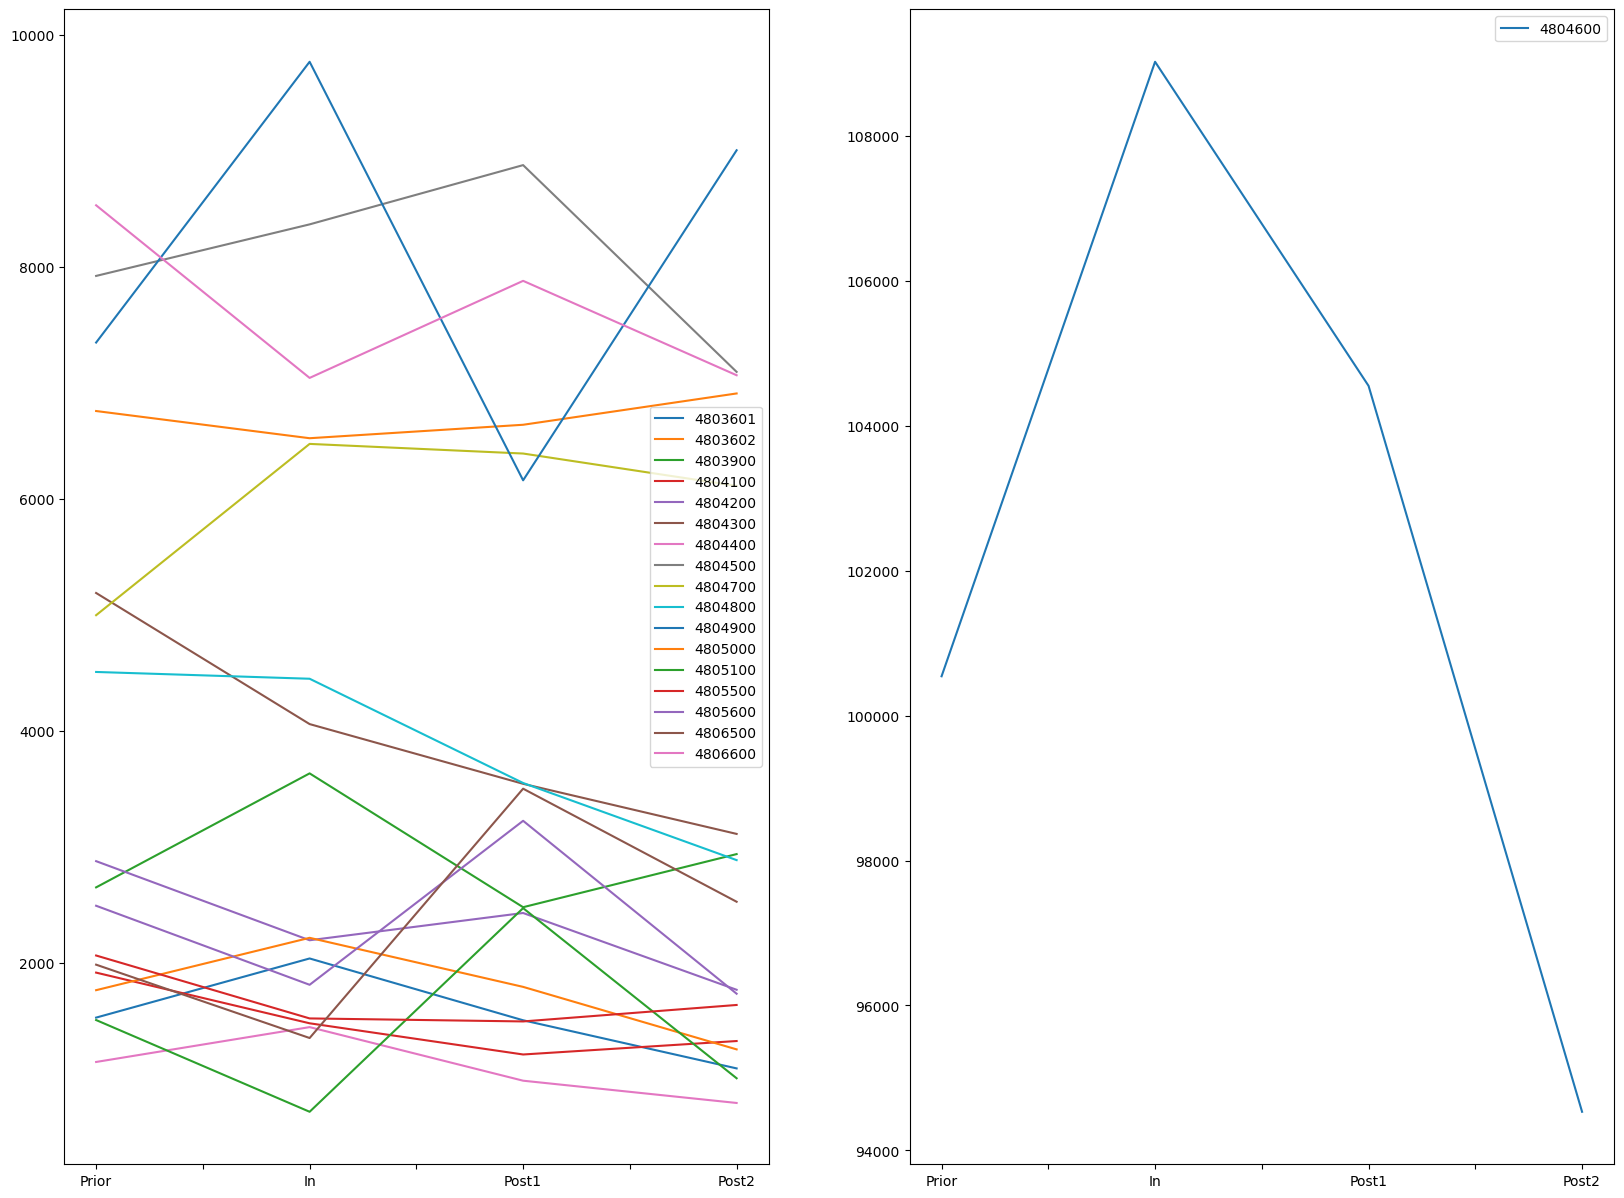

In [168]:
fig, axes = plt.subplots(1,2, figsize=(20, 15))
df_local_line_2.plot.line(ax=axes[0])
df_local_line_1.plot.line(ax=axes[1],legend=True)

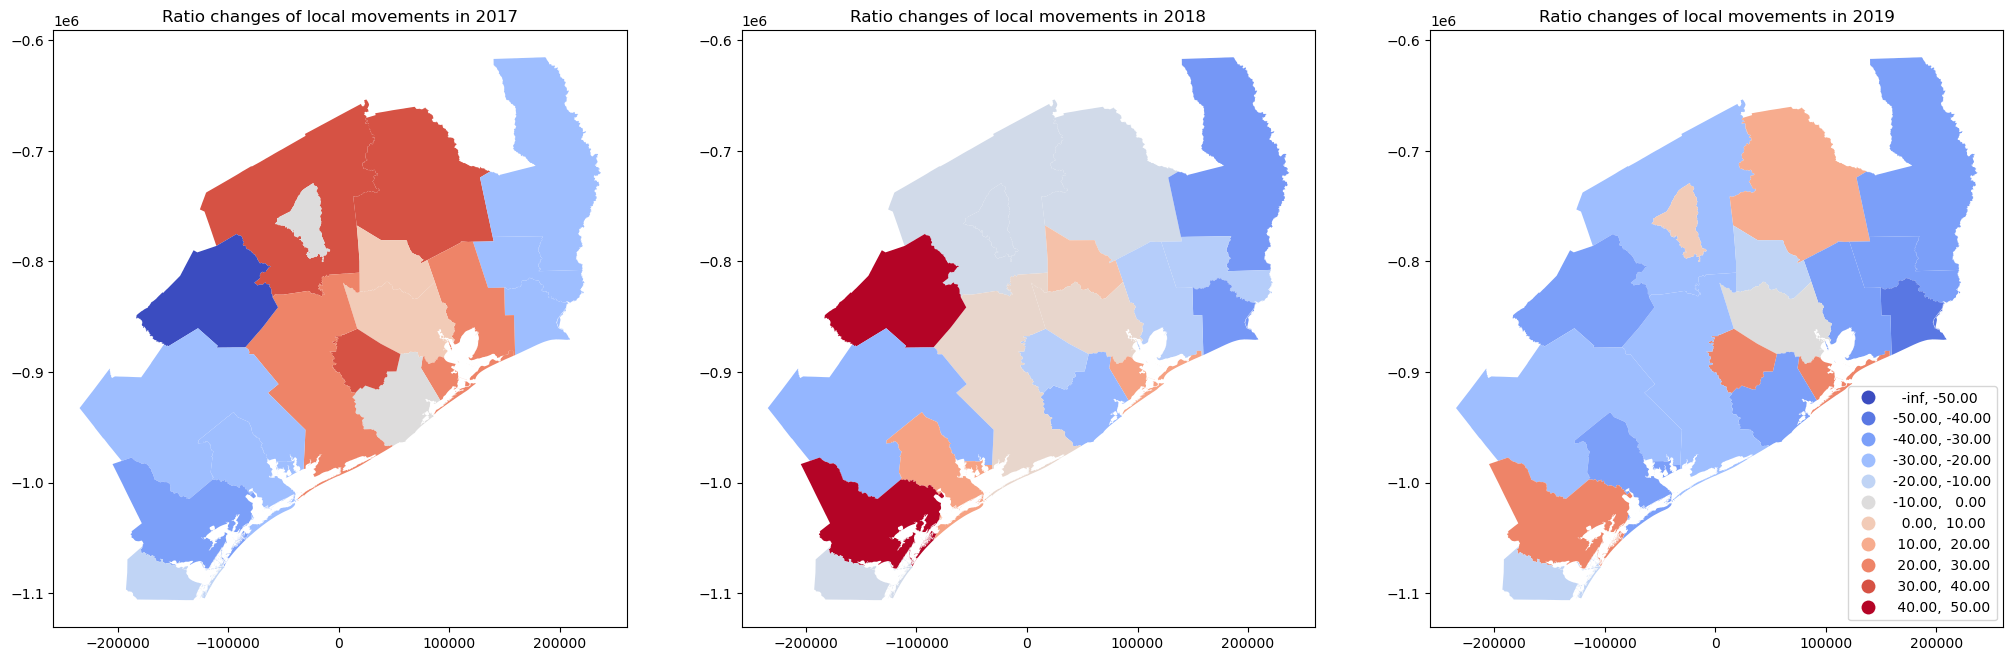

In [188]:
fig, axes = plt.subplots(1,3, figsize=(30, 21))
gdf_all_o_localmove.plot(column="cr_prior_in",cmap="coolwarm",
                         scheme='userdefined',classification_kwds={'bins':[ -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50]},
                         ax=axes[0])
axes[0].set_title("Ratio changes of local movements in 2017")
gdf_all_o_localmove.plot(column="cr_prior_post1",cmap="coolwarm",
                         scheme='userdefined',classification_kwds={'bins':[ -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50]},
                         ax=axes[1])
axes[1].set_title("Ratio changes of local movements in 2018")
gdf_all_o_localmove.plot(column="cr_prior_post2",cmap="coolwarm",
                         scheme='userdefined',classification_kwds={'bins':[ -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50]},
                         legend=True,ax=axes[2],legend_kwds={'loc': 'lower right'})
axes[2].set_title("Ratio changes of local movements in 2019")
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.75)

# 4 Outflows  <a id = "out"></a>

In [200]:
all_o_outflow = all_o[all_o["MIGPUMA_O"]!=all_o["MIGPUMA_D"]]
all_o_outflow_origin = all_o_outflow.groupby("MIGPUMA_O").sum(["PWGTP_Prior","PWGTP_In","PWGTP_Post1","PWGTP_Post2"]).reset_index()
all_o_outflow_dest = all_o_outflow.groupby("MIGPUMA_D").sum(["PWGTP_Prior","PWGTP_In","PWGTP_Post1","PWGTP_Post2"]).reset_index()

In [208]:
all_o_outflow_dest_merge   = pd.merge(all_o_outflow_dest,migpuma,left_on="MIGPUMA_D",right_on="MIGPUMA2")
all_o_outflow_dest_merge["cr_prior_in"] = (all_o_outflow_dest_merge["PWGTP_In"] - all_o_outflow_dest_merge["PWGTP_Prior"]) / all_o_outflow_dest_merge["PWGTP_Prior"]*100
all_o_outflow_dest_merge["cr_prior_post1"] = (all_o_outflow_dest_merge["PWGTP_Post1"] - all_o_outflow_dest_merge["PWGTP_Prior"]) / all_o_outflow_dest_merge["PWGTP_Prior"]*100
all_o_outflow_dest_merge["cr_prior_post2"] = (all_o_outflow_dest_merge["PWGTP_Post2"] - all_o_outflow_dest_merge["PWGTP_Prior"]) / all_o_outflow_dest_merge["PWGTP_Prior"]*100
gpd_all_o_outflow_dest     = gpd.GeoDataFrame(all_o_outflow_dest_merge,geometry="geometry")
all_o_outflow_origin_merge = pd.merge(all_o_outflow_origin,migpuma,left_on="MIGPUMA_O",right_on="MIGPUMA2")
all_o_outflow_origin_merge["cr_prior_in"] = (all_o_outflow_origin_merge["PWGTP_In"] - all_o_outflow_origin_merge["PWGTP_Prior"]) / all_o_outflow_origin_merge["PWGTP_Prior"]*100
all_o_outflow_origin_merge["cr_prior_post1"] = (all_o_outflow_origin_merge["PWGTP_Post1"] - all_o_outflow_origin_merge["PWGTP_Prior"]) / all_o_outflow_origin_merge["PWGTP_Prior"]*100
all_o_outflow_origin_merge["cr_prior_post2"] = (all_o_outflow_origin_merge["PWGTP_Post2"] - all_o_outflow_origin_merge["PWGTP_Prior"]) / all_o_outflow_origin_merge["PWGTP_Prior"]*100
gpd_all_o_outflow_origin   = gpd.GeoDataFrame(all_o_outflow_origin_merge,geometry="geometry")

In [227]:
List_out_prior = list(all_o_outflow_origin_merge["PWGTP_Prior"])
List_out_in = list(all_o_outflow_origin_merge["PWGTP_In"])
List_out_post1 = list(all_o_outflow_origin_merge["PWGTP_Post1"])
List_out_post2 = list(all_o_outflow_origin_merge["PWGTP_Post2"])
List_out_name = list(all_o_outflow_origin_merge["MIGPUMA_O"])
df_out_line = pd.DataFrame(np.array([List_out_prior,List_out_in,List_out_post1,List_out_post2]),
                             columns=List_out_name,index=["Prior","In","Post1","Post2"])

In [228]:
df_out_line_1=df_out_line["4804600"]
df_out_line_2=df_out_line.drop("4804600",axis=1)

<AxesSubplot: >

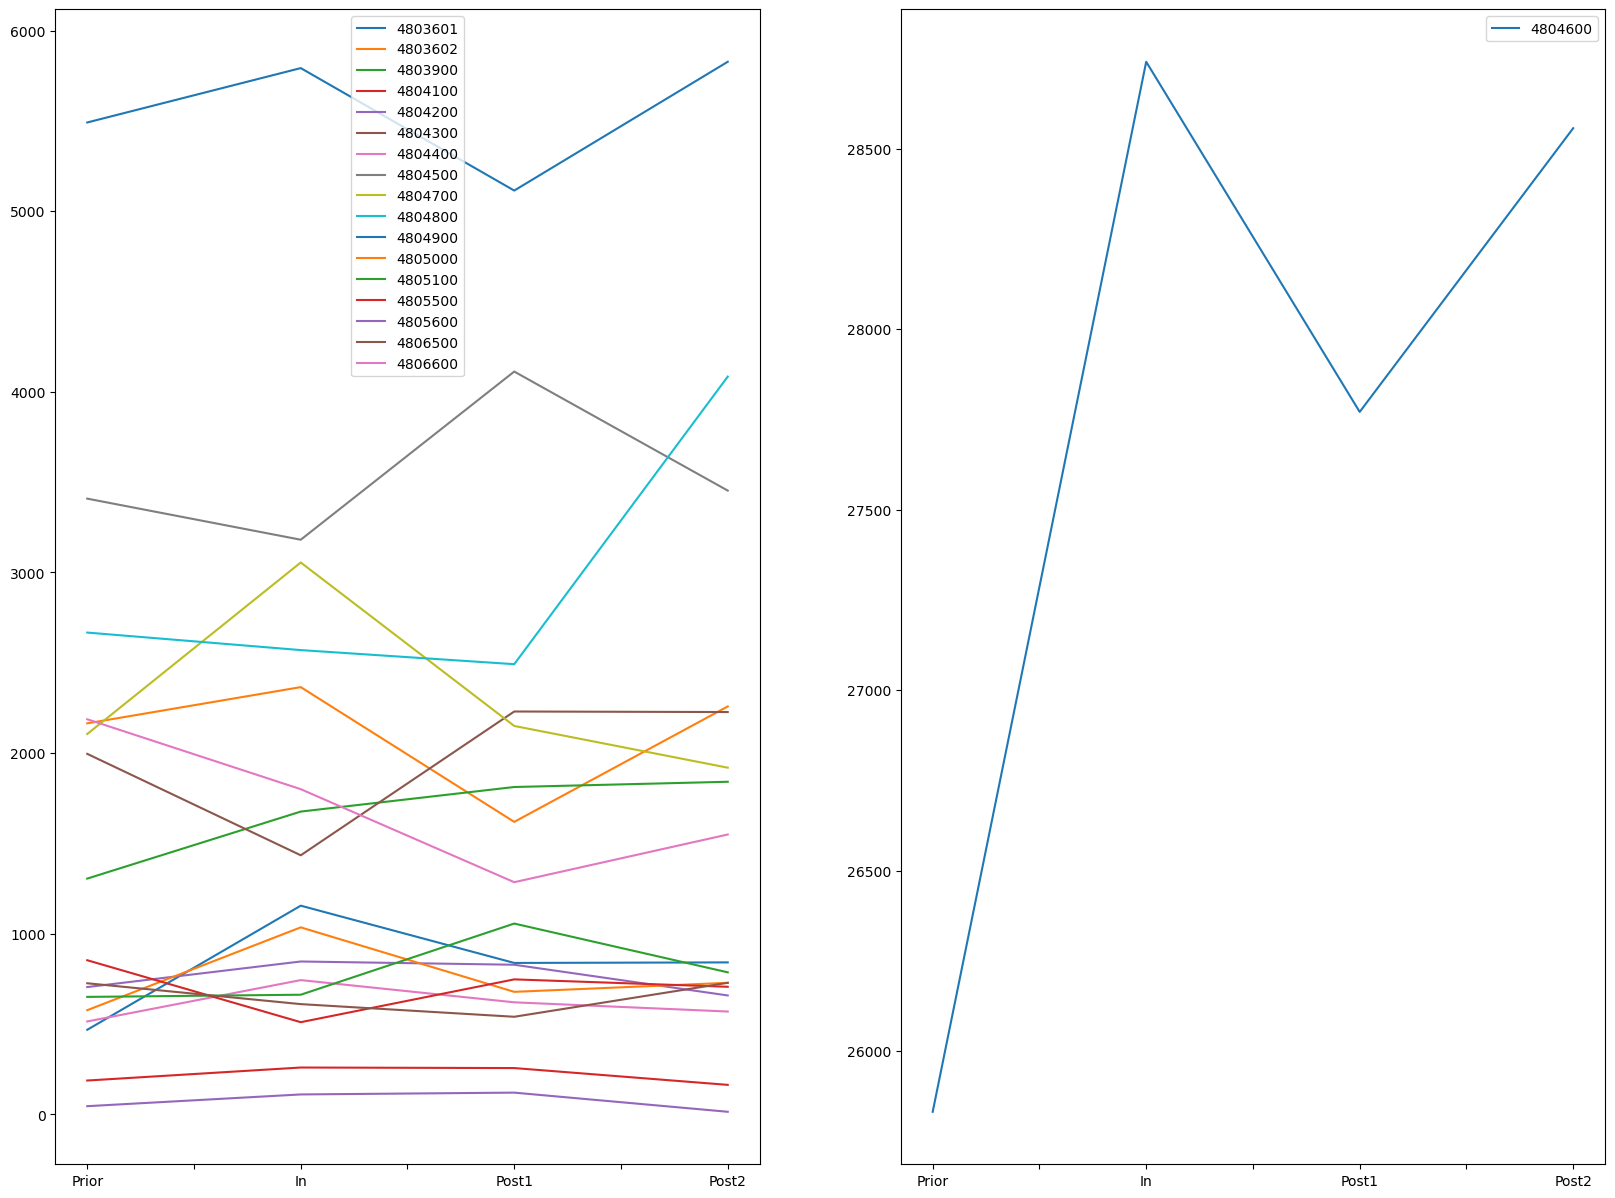

In [231]:
fig, axes = plt.subplots(1,2, figsize=(20, 15))
df_out_line_2.plot.line(ax=axes[0])
df_out_line_1.plot.line(ax=axes[1],legend=True)

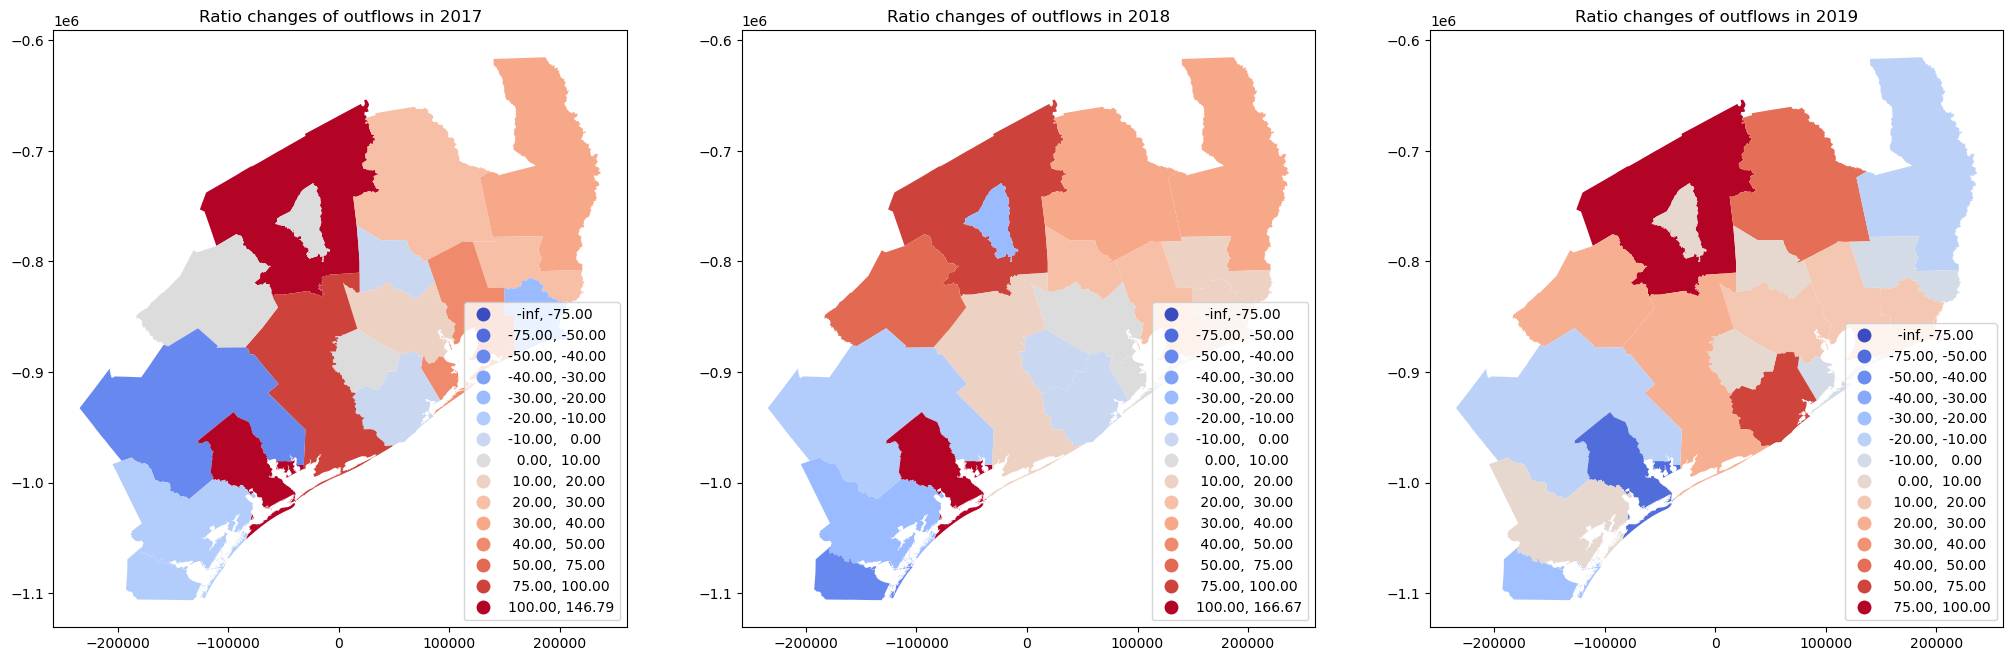

In [215]:
fig, axes = plt.subplots(1,3, figsize=(30, 20))
gpd_all_o_outflow_origin.plot(column="cr_prior_in",cmap="coolwarm",
                         scheme='userdefined',classification_kwds={'bins':[ -75, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 75, 100]},
                         legend=True,ax=axes[0],legend_kwds={'loc': 'lower right'})
axes[0].set_title("Ratio changes of outflows in 2017")
gpd_all_o_outflow_origin.plot(column="cr_prior_post1",cmap="coolwarm",
                         scheme='userdefined',classification_kwds={'bins':[ -75, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 75, 100]},
                         legend=True,ax=axes[1],legend_kwds={'loc': 'lower right'})
axes[1].set_title("Ratio changes of outflows in 2018")
gpd_all_o_outflow_origin.plot(column="cr_prior_post2",cmap="coolwarm",
                         scheme='userdefined',classification_kwds={'bins':[ -75, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 75, 100]},
                         legend=True,ax=axes[2],legend_kwds={'loc': 'lower right'})
axes[2].set_title("Ratio changes of outflows in 2019")
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.75)

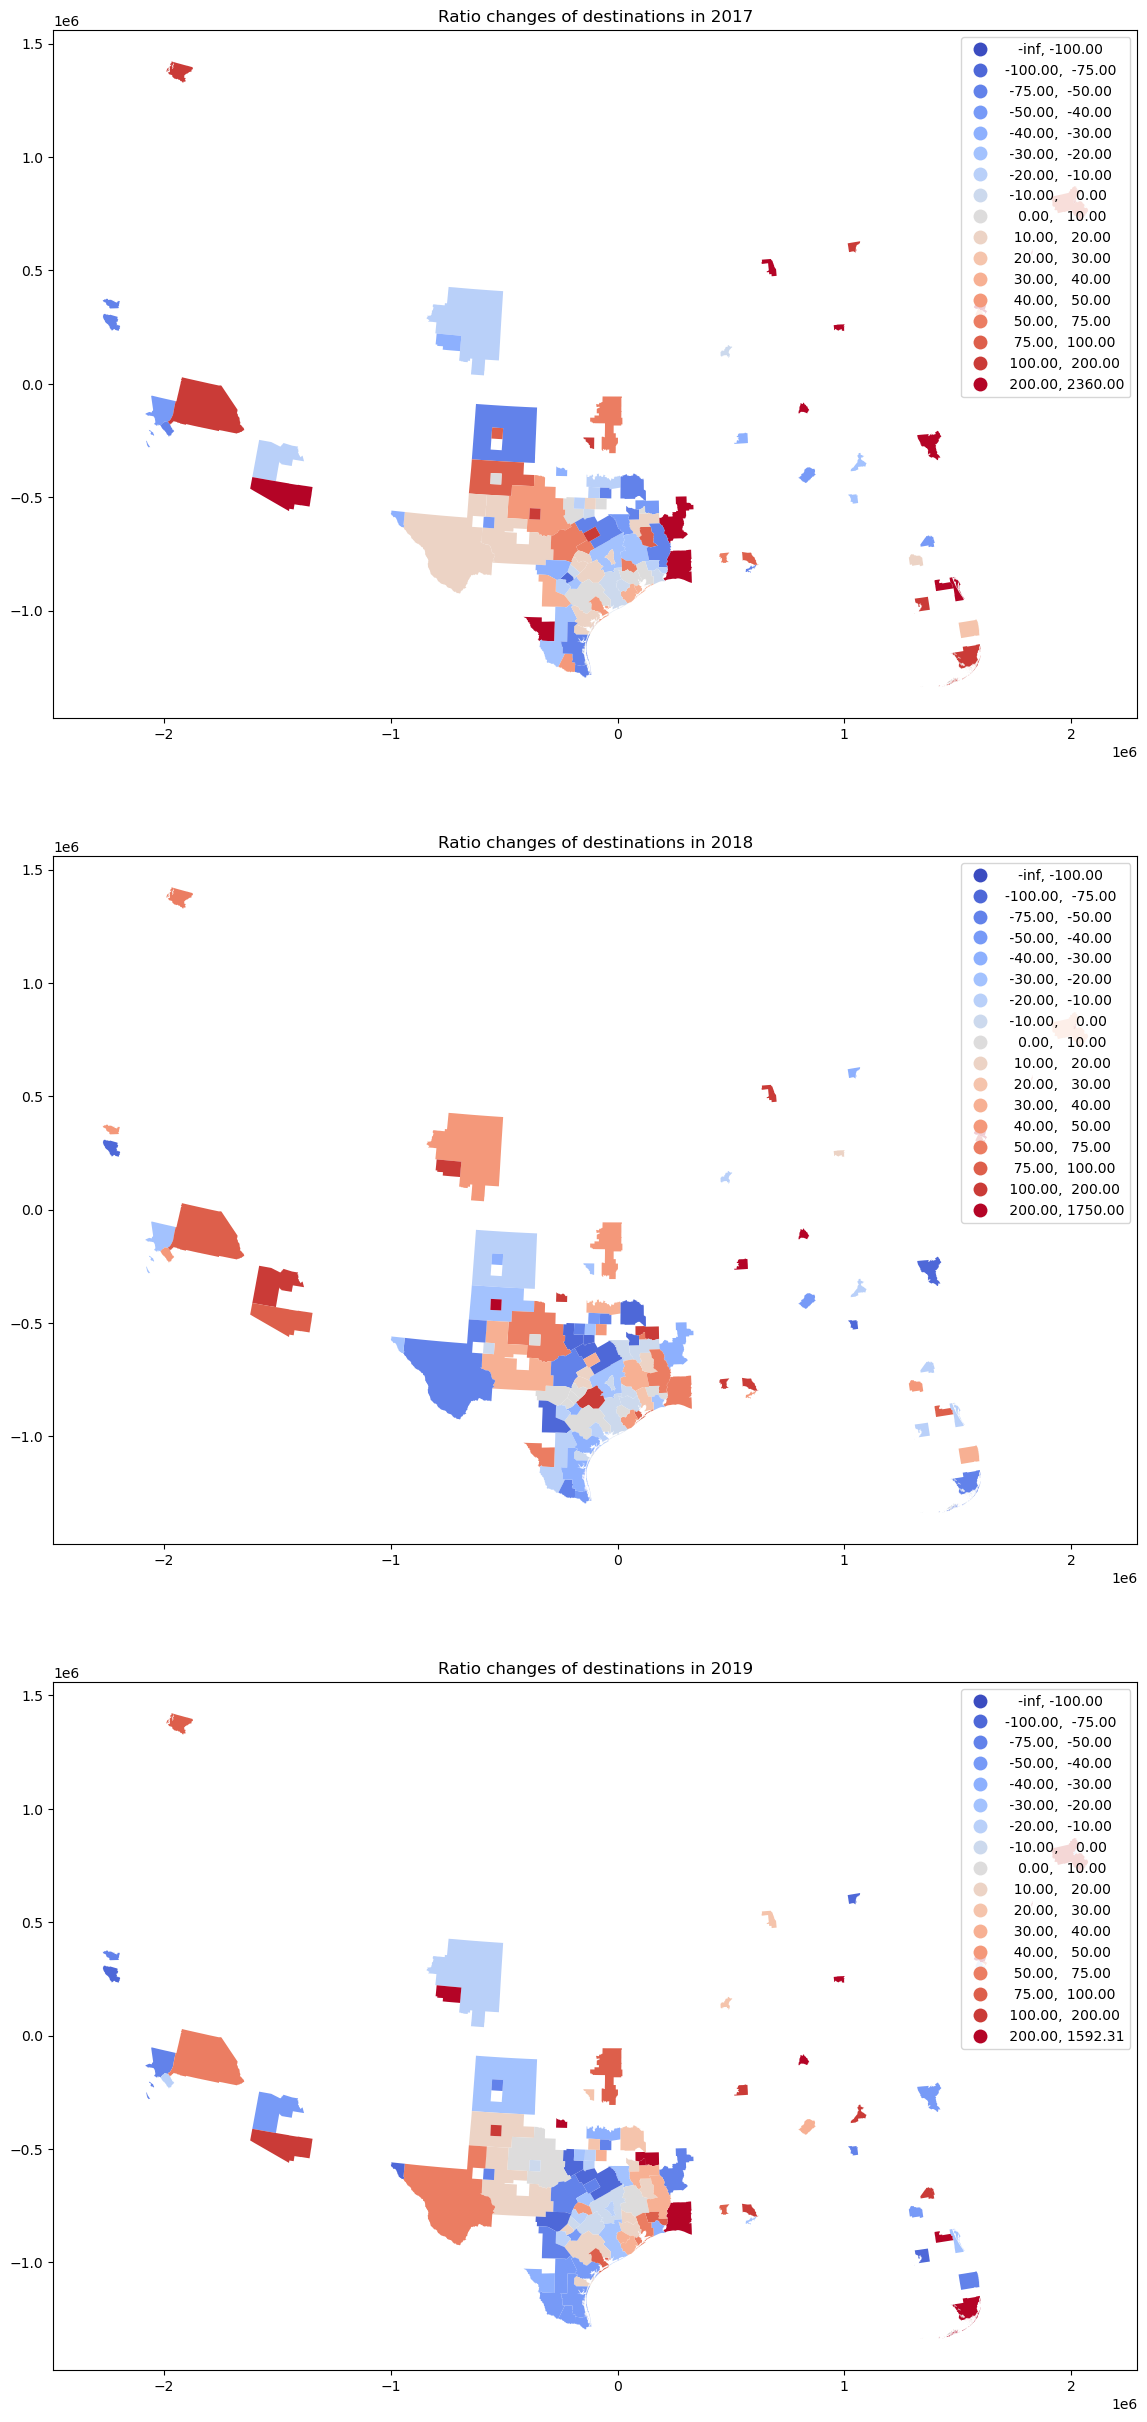

In [222]:
fig, axes = plt.subplots(3,1, figsize=(50, 30))
gpd_all_o_outflow_dest.plot(column="cr_prior_in",cmap="coolwarm",
                         scheme='userdefined',classification_kwds={'bins':[ -100, -75, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 75, 100, 200]},
                         legend=True,ax=axes[0],legend_kwds={'loc': 'best'})
axes[0].set_title("Ratio changes of destinations in 2017")
gpd_all_o_outflow_dest.plot(column="cr_prior_post1",cmap="coolwarm",
                         scheme='userdefined',classification_kwds={'bins':[ -100, -75, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 75, 100, 200]},
                         legend=True,ax=axes[1],legend_kwds={'loc': 'best'})
axes[1].set_title("Ratio changes of destinations in 2018")
gpd_all_o_outflow_dest.plot(column="cr_prior_post2",cmap="coolwarm",
                         scheme='userdefined',classification_kwds={'bins':[ -100, -75, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 75, 100, 200]},
                         legend=True,ax=axes[2],legend_kwds={'loc': 'best'})
axes[2].set_title("Ratio changes of destinations in 2019")
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.75)

In [262]:
all_o_outflow_1 = pd.merge(all_o_outflow,migpuma_p,left_on="MIGPUMA_O",right_on="MIGPUMA2")
all_o_outflow_2 = pd.merge(all_o_outflow_1,migpuma_p,left_on="MIGPUMA_D",right_on="MIGPUMA2")

In [264]:
df_line = pd.DataFrame()
df_line["geometry"] = all_o_outflow_2.apply(lambda x: LineString([x["geometry_x"],x["geometry_y"]]),axis=1)
df_line = gpd.GeoDataFrame(df_line,geometry="geometry",crs = 'ESRI:102003').to_crs("EPSG:4326")
df_line[["PWGTP_Prior","PWGTP_In","PWGTP_Post1","PWGTP_Post2","MIGPUMA_O","MIGPUMA_D"]] = all_o_outflow_2[["PWGTP_Prior","PWGTP_In","PWGTP_Post1","PWGTP_Post2","MIGPUMA_O","MIGPUMA_D"]]

C:\Users\xiang11\.conda\envs\geo\lib\site-packages\pandas\core\dtypes\cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [268]:
def x_y_o_d(gdf):
    gdf['x_o'] = gdf.geometry.apply(lambda geom: geom.coords[0][0])
    gdf['y_o'] = gdf.geometry.apply(lambda geom: geom.coords[0][1])
    gdf['x_d'] = gdf.geometry.apply(lambda geom: geom.coords[1][0])
    gdf['y_d'] = gdf.geometry.apply(lambda geom: geom.coords[1][1])
    gdf['Dist'] = gdf.apply(lambda row: GD((row['y_o'], row['x_o']), (row['y_d'], row['x_d'])).km, axis=1)
    gdf = gpd.GeoDataFrame(gdf,geometry="geometry",crs ="EPSG:4326" ).to_crs('ESRI:102003')
    gdf['x_o'] = gdf.geometry.apply(lambda geom: geom.coords[0][0])
    gdf['y_o'] = gdf.geometry.apply(lambda geom: geom.coords[0][1])
    gdf['x_d'] = gdf.geometry.apply(lambda geom: geom.coords[1][0])
    gdf['y_d'] = gdf.geometry.apply(lambda geom: geom.coords[1][1])
    return gdf

In [282]:
gdf_od= x_y_o_d(df_line)
gdf_od["cr_prior_in"] = (gdf_od["PWGTP_In"] - gdf_od["PWGTP_Prior"]) / gdf_od["PWGTP_Prior"]*100
gdf_od["cr_prior_post1"] = (gdf_od["PWGTP_Post1"] - gdf_od["PWGTP_Prior"]) / gdf_od["PWGTP_Prior"]*100
gdf_od["cr_prior_post2"] = (gdf_od["PWGTP_Post2"] - gdf_od["PWGTP_Prior"]) / gdf_od["PWGTP_Prior"]*100

In [301]:
gdf_od_150 = gdf_od[gdf_od["Dist"]<150]
gdf_od_over150 = gdf_od[gdf_od["Dist"]>=150]

### The data is based on ratio changes, and red represents increase and blue represents the decrease.

Text(0.5, 1.0, 'Flow Map in 150km Range in 2019\n compared to baseline')

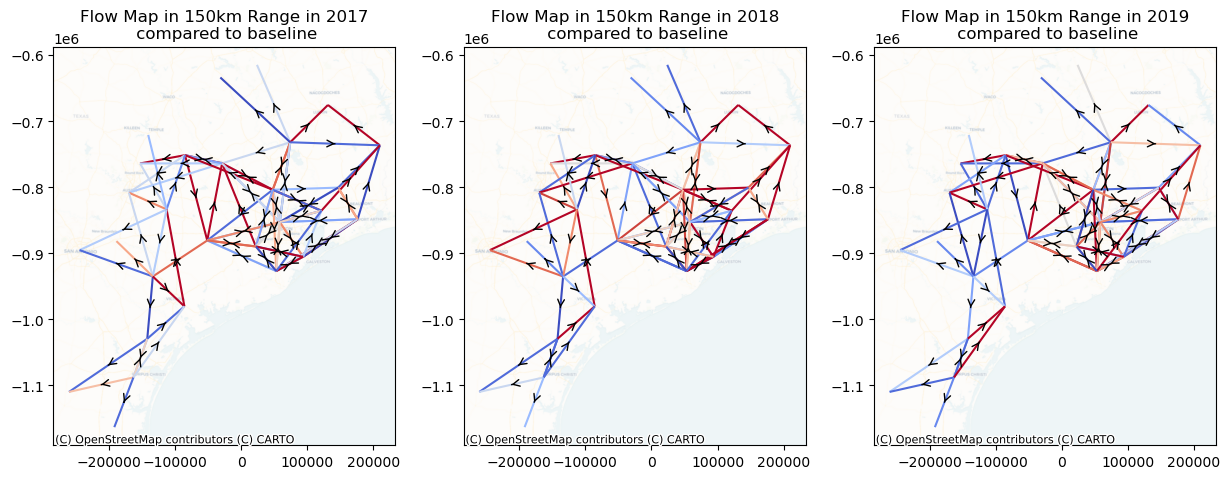

In [295]:
fig, axes = plt.subplots(1,3)
for i in range(len(gdf_od_150)):
    x0 = gdf_od_150[i:i+1]["x_o"]
    x1 = gdf_od_150[i:i+1]["x_d"]
    y0 = gdf_od_150[i:i+1]["y_o"]
    y1 = gdf_od_150[i:i+1]["y_d"]
    xpos = (x0+x1)/2
    ypos = (y0+y1)/2
    xdir = x1-x0
    ydir = y1-y0
    for X,Y,dX,dY in zip(xpos, ypos, xdir, ydir):
        axes[0].annotate("", xytext=(X,Y),xy=(X+0.001*dX,Y+0.001*dY), 
        arrowprops=dict(arrowstyle="->", color='k'), size = 12)
        axes[1].annotate("", xytext=(X,Y),xy=(X+0.001*dX,Y+0.001*dY), 
        arrowprops=dict(arrowstyle="->", color='k'), size = 12)
        axes[2].annotate("", xytext=(X,Y),xy=(X+0.001*dX,Y+0.001*dY), 
        arrowprops=dict(arrowstyle="->", color='k'), size = 12)
gdf_od_150.plot(column='cr_prior_in',
     cmap='coolwarm',
     scheme='userdefined',classification_kwds={'bins':[ -75, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 75, 100]},
     alpha = 1,
     ax=axes[0])
cx.add_basemap(ax=axes[0],source=cx.providers.CartoDB.Voyager,crs=gdf_od.crs,alpha = 0.4)
axes[0].set_title("Flow Map in 150km Range in 2017\n compared to baseline")
gdf_od_150.plot(column='cr_prior_post1',
     cmap='coolwarm',
     scheme='userdefined',classification_kwds={'bins':[ -75, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 75, 100]},
     alpha = 1,
     ax=axes[1])
cx.add_basemap(ax=axes[1],source=cx.providers.CartoDB.Voyager,crs=gdf_od.crs,alpha = 0.4)
axes[1].set_title("Flow Map in 150km Range in 2018\n compared to baseline")
gdf_od_150.plot(column='cr_prior_post2',
     cmap='coolwarm',
     scheme='userdefined',classification_kwds={'bins':[ -75, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 75, 100]},
     alpha = 1,
     ax=axes[2])
cx.add_basemap(ax=axes[2],source=cx.providers.CartoDB.Voyager,crs=gdf_od.crs,alpha = 0.4)
axes[2].set_title("Flow Map in 150km Range in 2019\n compared to baseline")

Text(0.5, 1.0, 'Flow Map over 150km Range in 2019\n compared to baseline')

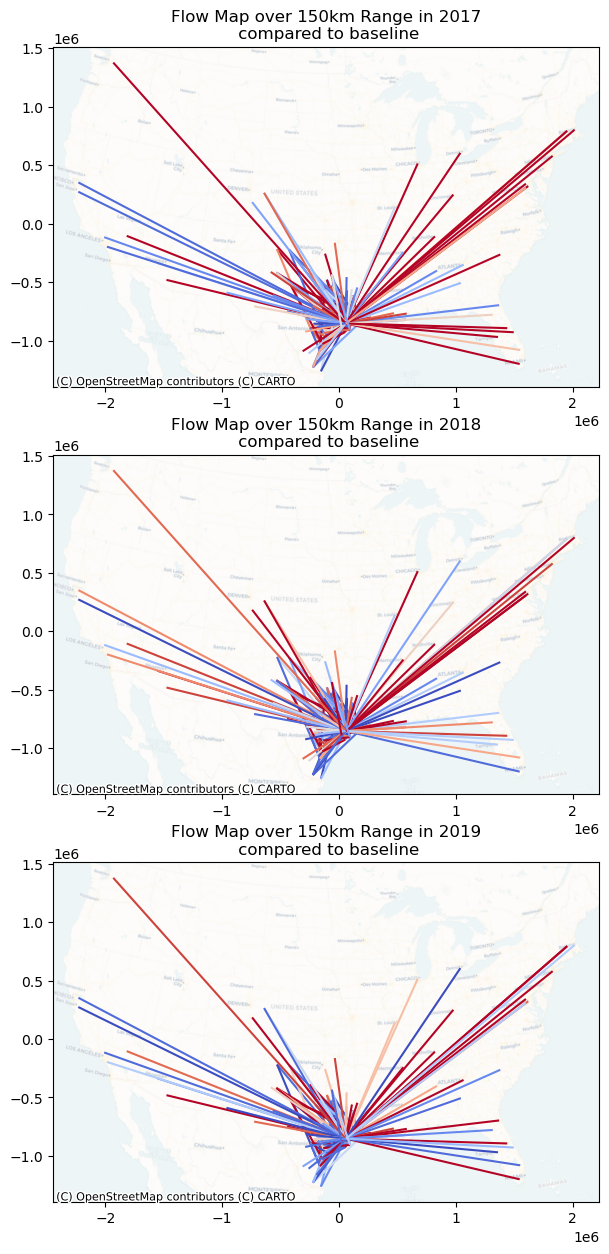

In [302]:
fig, axes = plt.subplots(3,1)
# for i in range(len(gdf_od_over150)):
#     x0 = gdf_od_over150[i:i+1]["x_o"]
#     x1 = gdf_od_over150[i:i+1]["x_d"]
#     y0 = gdf_od_over150[i:i+1]["y_o"]
#     y1 = gdf_od_over150[i:i+1]["y_d"]
#     xpos = (x0+x1)/2
#     ypos = (y0+y1)/2
#     xdir = x1-x0
#     ydir = y1-y0
#     for X,Y,dX,dY in zip(xpos, ypos, xdir, ydir):
#         axes[0].annotate("", xytext=(X,Y),xy=(X+0.001*dX,Y+0.001*dY), 
#         arrowprops=dict(arrowstyle="->", color='k'), size = 12)
#         axes[1].annotate("", xytext=(X,Y),xy=(X+0.001*dX,Y+0.001*dY), 
#         arrowprops=dict(arrowstyle="->", color='k'), size = 12)
#         axes[2].annotate("", xytext=(X,Y),xy=(X+0.001*dX,Y+0.001*dY), 
#         arrowprops=dict(arrowstyle="->", color='k'), size = 12)
gdf_od_over150.plot(column='cr_prior_in',
     cmap='coolwarm',
     scheme='userdefined',classification_kwds={'bins':[ -75, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 75, 100]},
     alpha = 1,
     ax=axes[0])
cx.add_basemap(ax=axes[0],source=cx.providers.CartoDB.Voyager,crs=gdf_od.crs,alpha = 0.4)
axes[0].set_title("Flow Map over 150km Range in 2017\n compared to baseline")
gdf_od_over150.plot(column='cr_prior_post1',
     cmap='coolwarm',
     scheme='userdefined',classification_kwds={'bins':[ -75, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 75, 100]},
     alpha = 1,
     ax=axes[1])
cx.add_basemap(ax=axes[1],source=cx.providers.CartoDB.Voyager,crs=gdf_od.crs,alpha = 0.4)
axes[1].set_title("Flow Map over 150km Range in 2018\n compared to baseline")
gdf_od_over150.plot(column='cr_prior_post2',
     cmap='coolwarm',
     scheme='userdefined',classification_kwds={'bins':[ -75, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 75, 100]},
     alpha = 1,
     ax=axes[2])
cx.add_basemap(ax=axes[2],source=cx.providers.CartoDB.Voyager,crs=gdf_od.crs,alpha = 0.4)
axes[2].set_title("Flow Map over 150km Range in 2019\n compared to baseline")

# 5 Inflow <a id = "in"></a>

In [233]:
merge_d_15_16 = pd.merge(df_prior_d_2,df_prior_d_1,left_on=["MIGPUMA_O_2015","MIGPUMA_D_2015"],
                         right_on=["MIGPUMA_O_2016","MIGPUMA_D_2016"],how="outer")
listNum = []
merge_d_15_16 = merge_d_15_16.fillna(0)
for i in range(len(merge_d_15_16)):
    List = []
    List.append(int(merge_d_15_16[i:i+1]["PWGTP_2015"]))
    List.append(int(merge_d_15_16[i:i+1]["PWGTP_2016"]))
    number = 2 - int(List.count(0))
    listNum.append(number)
merge_d_15_16["countNum"] = listNum
merge_d_15_16["PWGTP_AVG"] = (merge_d_15_16["PWGTP_2015"]+merge_d_15_16["PWGTP_2016"])/merge_d_15_16["countNum"]

In [234]:
list_d_o_1 = list(merge_d_15_16["MIGPUMA_O_2015"])
list_d_o_2 = list(merge_d_15_16["MIGPUMA_O_2016"])
list_d_d_1 = list(merge_d_15_16["MIGPUMA_D_2015"])
list_d_d_2 = list(merge_d_15_16["MIGPUMA_D_2016"])
list_d_Pop = list(merge_d_15_16["PWGTP_AVG"])

In [235]:
list_o = []
list_d = []
for i in range(len(list_d_o_1)):
    if list_d_o_1[i] == 0:
        list_o.append(list_d_o_2[i])
    else:
        list_o.append(list_d_o_1[i])

for i in range(len(list_d_d_1)):
    if list_d_d_1[i] == 0:
        list_d.append(list_d_d_2[i])
    else:
        list_d.append(list_d_d_1[i])

In [237]:
df_d_15_16 = pd.DataFrame(data={
    "MIGPUMA_O":list_o,
    "MIGPUMA_D":list_d,
    "PWGTP_AVG":list_d_Pop
})

In [238]:
merge_all_d_1 = pd.merge(df_d_15_16,df_in_d,left_on=["MIGPUMA_O","MIGPUMA_D"],
                       right_on=["MIGPUMA_O_2017","MIGPUMA_D_2017"],how="inner")
merge_all_d_2 = pd.merge(merge_all_d_1,df_post_d_1,left_on=["MIGPUMA_O","MIGPUMA_D"],
                       right_on=["MIGPUMA_O_2018","MIGPUMA_D_2018"],how="inner")
merge_all_d = pd.merge(merge_all_d_2,df_post_d_2,left_on=["MIGPUMA_O","MIGPUMA_D"],
                     right_on=["MIGPUMA_O_2019","MIGPUMA_D_2019"],how="inner")

In [240]:
all_d = merge_all_d[["MIGPUMA_O","MIGPUMA_D","PWGTP_AVG","PWGTP_2017","PWGTP_2018","PWGTP_2019"]]
all_d = all_d.rename(columns={"PWGTP_AVG":"PWGTP_Prior","PWGTP_2017":"PWGTP_In","PWGTP_2018":"PWGTP_Post1","PWGTP_2019":"PWGTP_Post2"})

In [243]:
all_d_inflow = all_d[all_d["MIGPUMA_O"]!=all_d["MIGPUMA_D"]]
all_d_inflow_origin = all_d_inflow.groupby("MIGPUMA_O").sum(["PWGTP_Prior","PWGTP_In","PWGTP_Post1","PWGTP_Post2"]).reset_index()
all_d_inflow_dest = all_d_inflow.groupby("MIGPUMA_D").sum(["PWGTP_Prior","PWGTP_In","PWGTP_Post1","PWGTP_Post2"]).reset_index()

In [245]:
all_d_inflow_dest_merge   = pd.merge(all_d_inflow_dest,migpuma,left_on="MIGPUMA_D",right_on="MIGPUMA2")
all_d_inflow_dest_merge["cr_prior_in"] = (all_d_inflow_dest_merge["PWGTP_In"] - all_d_inflow_dest_merge["PWGTP_Prior"]) / all_d_inflow_dest_merge["PWGTP_Prior"]*100
all_d_inflow_dest_merge["cr_prior_post1"] = (all_d_inflow_dest_merge["PWGTP_Post1"] - all_d_inflow_dest_merge["PWGTP_Prior"]) / all_d_inflow_dest_merge["PWGTP_Prior"]*100
all_d_inflow_dest_merge["cr_prior_post2"] = (all_d_inflow_dest_merge["PWGTP_Post2"] - all_d_inflow_dest_merge["PWGTP_Prior"]) / all_d_inflow_dest_merge["PWGTP_Prior"]*100
gpd_all_d_inflow_dest     = gpd.GeoDataFrame(all_d_inflow_dest_merge,geometry="geometry")
all_d_inflow_origin_merge = pd.merge(all_d_inflow_origin,migpuma,left_on="MIGPUMA_O",right_on="MIGPUMA2")
all_d_inflow_origin_merge["cr_prior_in"] = (all_d_inflow_origin_merge["PWGTP_In"] - all_d_inflow_origin_merge["PWGTP_Prior"]) / all_d_inflow_origin_merge["PWGTP_Prior"]*100
all_d_inflow_origin_merge["cr_prior_post1"] = (all_d_inflow_origin_merge["PWGTP_Post1"] - all_d_inflow_origin_merge["PWGTP_Prior"]) / all_d_inflow_origin_merge["PWGTP_Prior"]*100
all_d_inflow_origin_merge["cr_prior_post2"] = (all_d_inflow_origin_merge["PWGTP_Post2"] - all_d_inflow_origin_merge["PWGTP_Prior"]) / all_d_inflow_origin_merge["PWGTP_Prior"]*100
gpd_all_d_inflow_origin   = gpd.GeoDataFrame(all_d_inflow_origin_merge,geometry="geometry")

In [248]:
List_in_prior = list(all_d_inflow_dest_merge["PWGTP_Prior"])
List_in_in = list(all_d_inflow_dest_merge["PWGTP_In"])
List_in_post1 = list(all_d_inflow_dest_merge["PWGTP_Post1"])
List_in_post2 = list(all_d_inflow_dest_merge["PWGTP_Post2"])
List_in_name = list(all_d_inflow_dest_merge["MIGPUMA_D"])
df_in_line = pd.DataFrame(np.array([List_in_prior,List_in_in,List_in_post1,List_in_post2]),
                             columns=List_in_name,index=["Prior","In","Post1","Post2"])

In [249]:
df_in_line_1=df_in_line["4804600"]
df_in_line_2=df_in_line.drop("4804600",axis=1)

<AxesSubplot: >

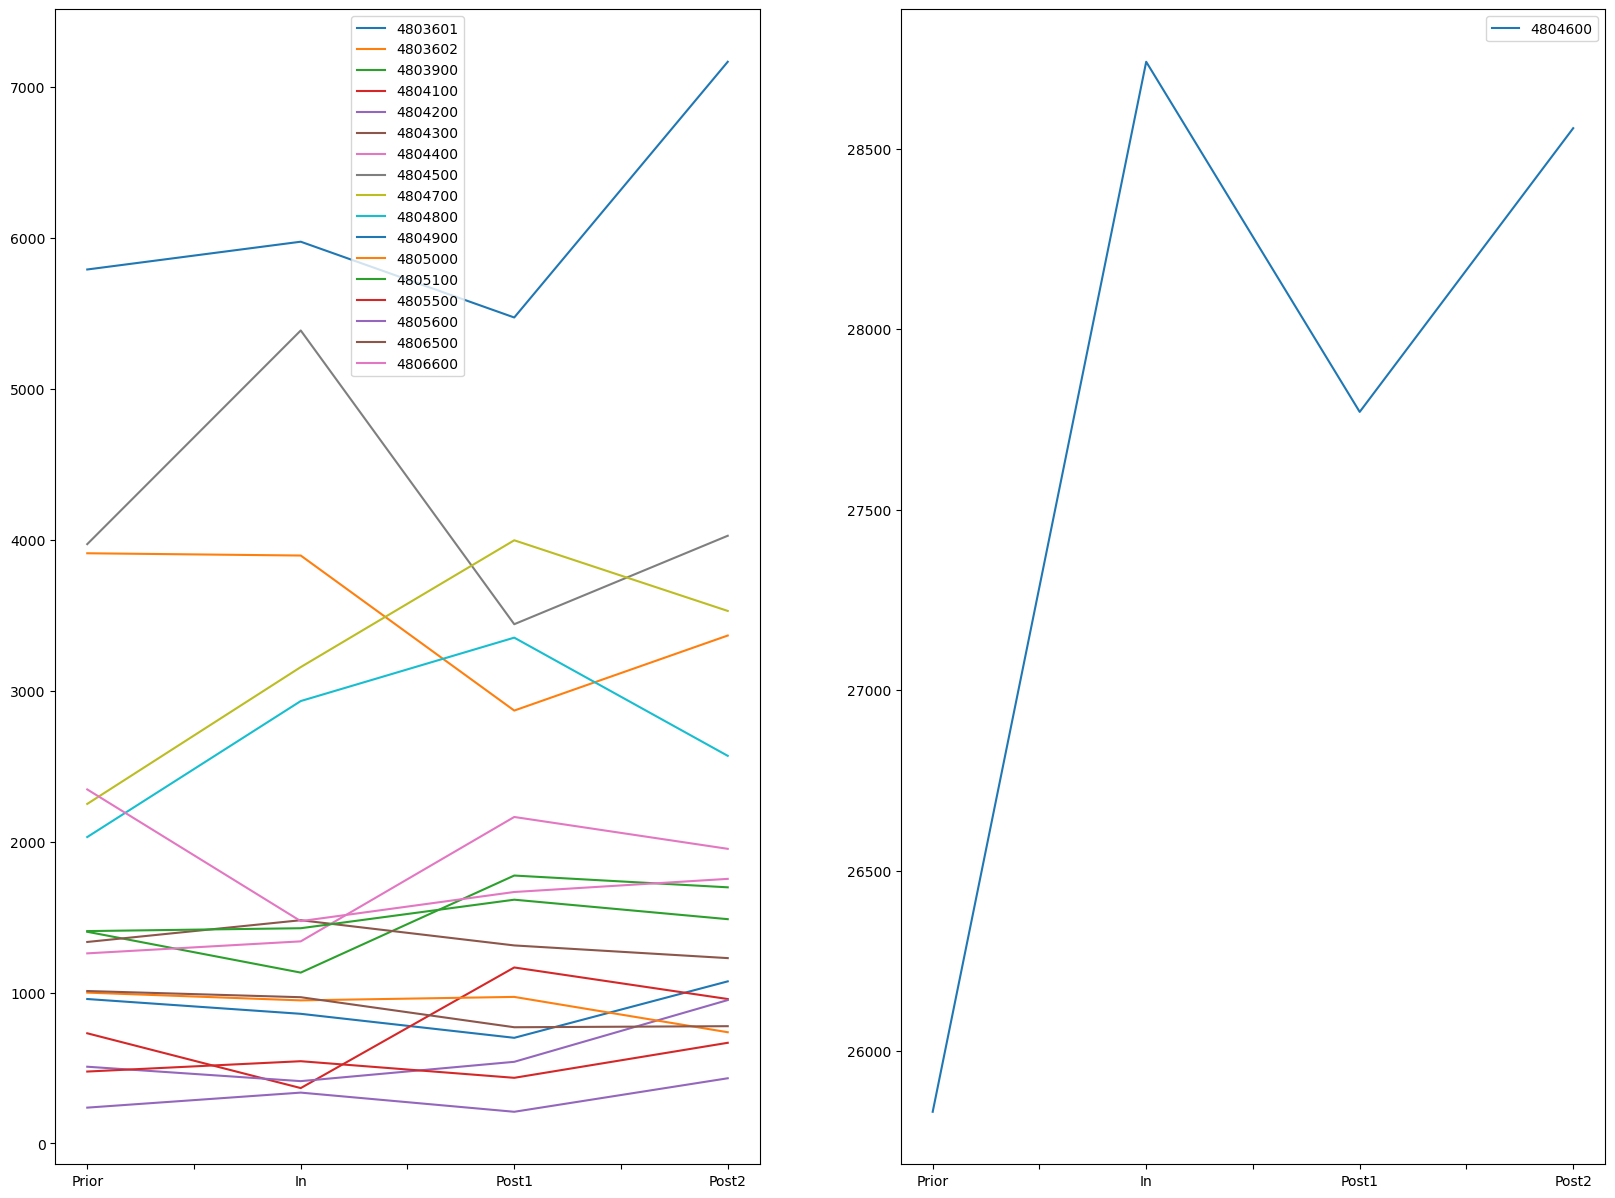

In [250]:
fig, axes = plt.subplots(1,2, figsize=(20, 15))
df_in_line_2.plot.line(ax=axes[0])
df_out_line_1.plot.line(ax=axes[1],legend=True)

### These maps show the ratio changes of inflows' origin in each phase

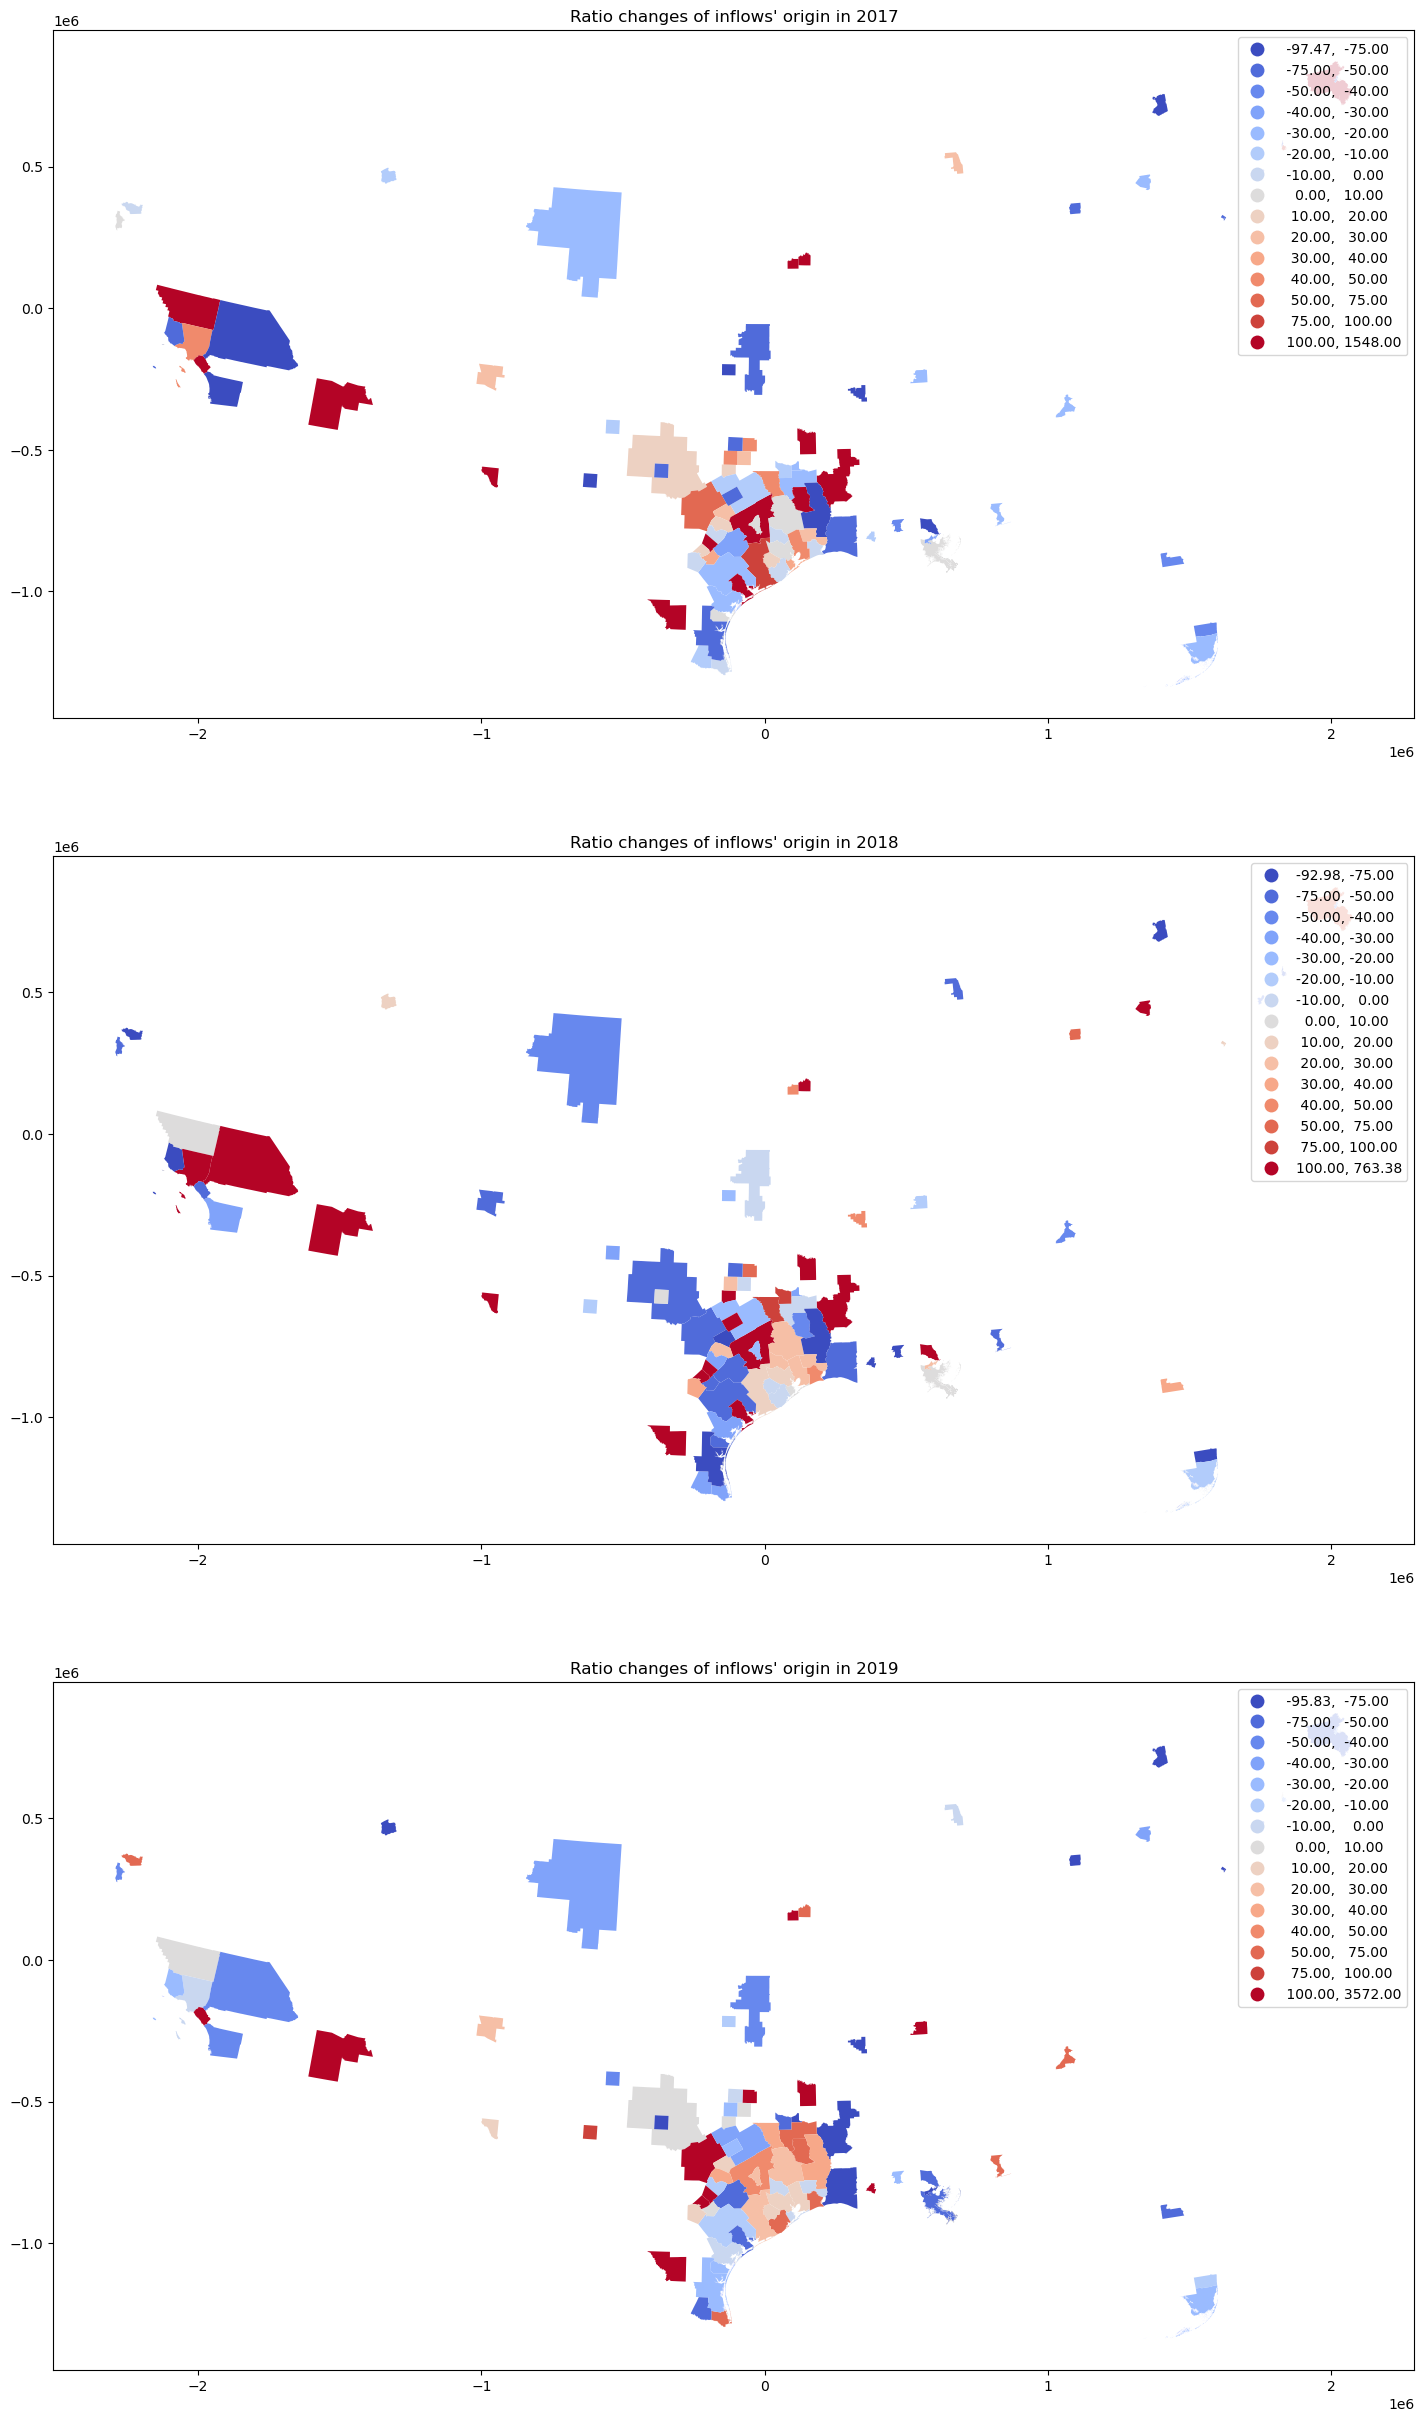

In [253]:
fig, axes = plt.subplots(3,1, figsize=(50, 30))
gpd_all_d_inflow_origin.plot(column="cr_prior_in",cmap="coolwarm",
                         scheme='userdefined',classification_kwds={'bins':[ -75, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 75, 100]},
                         legend=True,ax=axes[0],legend_kwds={'loc': 'best'})
axes[0].set_title("Ratio changes of inflows' origin in 2017")
gpd_all_d_inflow_origin.plot(column="cr_prior_post1",cmap="coolwarm",
                         scheme='userdefined',classification_kwds={'bins':[ -75, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 75, 100]},
                         legend=True,ax=axes[1],legend_kwds={'loc': 'best'})
axes[1].set_title("Ratio changes of inflows' origin in 2018")
gpd_all_d_inflow_origin.plot(column="cr_prior_post2",cmap="coolwarm",
                         scheme='userdefined',classification_kwds={'bins':[ -75, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 75, 100]},
                         legend=True,ax=axes[2],legend_kwds={'loc': 'best'})
axes[2].set_title("Ratio changes of inflows' origin in 2019")
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.75)

### These maps show the destination of inflows.

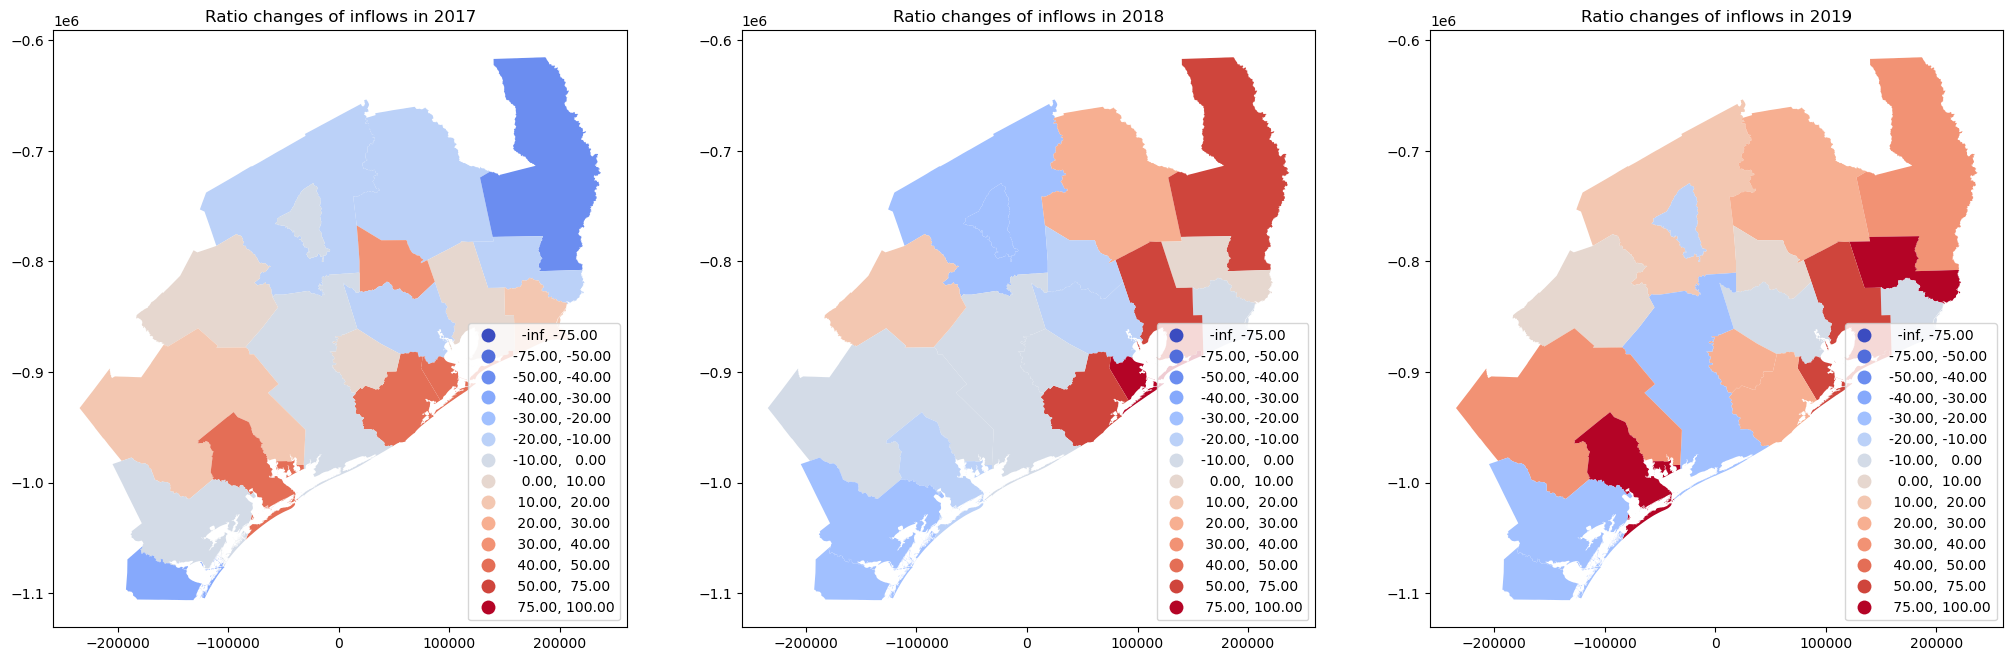

In [254]:
fig, axes = plt.subplots(1,3, figsize=(30, 20))
gpd_all_d_inflow_dest.plot(column="cr_prior_in",cmap="coolwarm",
                         scheme='userdefined',classification_kwds={'bins':[ -75, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 75, 100]},
                         legend=True,ax=axes[0],legend_kwds={'loc': 'lower right'})
axes[0].set_title("Ratio changes of inflows in 2017")
gpd_all_d_inflow_dest.plot(column="cr_prior_post1",cmap="coolwarm",
                         scheme='userdefined',classification_kwds={'bins':[ -75, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 75, 100]},
                         legend=True,ax=axes[1],legend_kwds={'loc': 'lower right'})
axes[1].set_title("Ratio changes of inflows in 2018")
gpd_all_d_inflow_dest.plot(column="cr_prior_post2",cmap="coolwarm",
                         scheme='userdefined',classification_kwds={'bins':[ -75, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 75, 100]},
                         legend=True,ax=axes[2],legend_kwds={'loc': 'lower right'})
axes[2].set_title("Ratio changes of inflows in 2019")
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.75)

In [305]:
all_d_inflow_1 = pd.merge(all_d_inflow,migpuma_p,left_on="MIGPUMA_O",right_on="MIGPUMA2")
all_d_inflow_2 = pd.merge(all_d_inflow_1,migpuma_p,left_on="MIGPUMA_D",right_on="MIGPUMA2")

In [306]:
df_line2 = pd.DataFrame()
df_line2["geometry"] = all_d_inflow_2.apply(lambda x: LineString([x["geometry_x"],x["geometry_y"]]),axis=1)
df_line2 = gpd.GeoDataFrame(df_line2,geometry="geometry",crs = 'ESRI:102003').to_crs("EPSG:4326")
df_line2[["PWGTP_Prior","PWGTP_In","PWGTP_Post1","PWGTP_Post2","MIGPUMA_O","MIGPUMA_D"]] = all_d_inflow_2[["PWGTP_Prior","PWGTP_In","PWGTP_Post1","PWGTP_Post2","MIGPUMA_O","MIGPUMA_D"]]

C:\Users\xiang11\.conda\envs\geo\lib\site-packages\pandas\core\dtypes\cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [307]:
gdf_od2= x_y_o_d(df_line2)
gdf_od2["cr_prior_in"] = (gdf_od2["PWGTP_In"] - gdf_od2["PWGTP_Prior"]) / gdf_od2["PWGTP_Prior"]*100
gdf_od2["cr_prior_post1"] = (gdf_od2["PWGTP_Post1"] - gdf_od2["PWGTP_Prior"]) / gdf_od2["PWGTP_Prior"]*100
gdf_od2["cr_prior_post2"] = (gdf_od2["PWGTP_Post2"] - gdf_od2["PWGTP_Prior"]) / gdf_od2["PWGTP_Prior"]*100

In [312]:
gdf_od2_150 = gdf_od2[gdf_od2["Dist"]<150]
gdf_od2_over150 = gdf_od2[gdf_od2["Dist"]>=150]

Text(0.5, 1.0, 'Inflow Map in 150km Range in 2019\n compared to baseline')

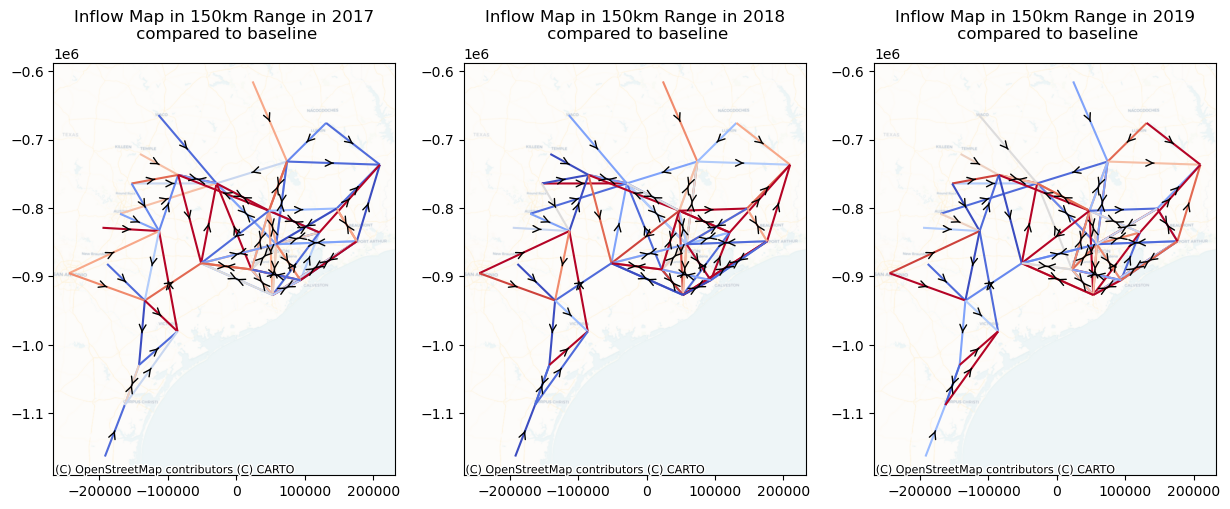

In [314]:
fig, axes = plt.subplots(1,3)
for i in range(len(gdf_od2_150)):
    x0 = gdf_od2_150[i:i+1]["x_o"]
    x1 = gdf_od2_150[i:i+1]["x_d"]
    y0 = gdf_od2_150[i:i+1]["y_o"]
    y1 = gdf_od2_150[i:i+1]["y_d"]
    xpos = (x0+x1)/2
    ypos = (y0+y1)/2
    xdir = x1-x0
    ydir = y1-y0
    for X,Y,dX,dY in zip(xpos, ypos, xdir, ydir):
        axes[0].annotate("", xytext=(X,Y),xy=(X+0.001*dX,Y+0.001*dY), 
        arrowprops=dict(arrowstyle="->", color='k'), size = 12)
        axes[1].annotate("", xytext=(X,Y),xy=(X+0.001*dX,Y+0.001*dY), 
        arrowprops=dict(arrowstyle="->", color='k'), size = 12)
        axes[2].annotate("", xytext=(X,Y),xy=(X+0.001*dX,Y+0.001*dY), 
        arrowprops=dict(arrowstyle="->", color='k'), size = 12)
gdf_od2_150.plot(column='cr_prior_in',
     cmap='coolwarm',
     scheme='userdefined',classification_kwds={'bins':[ -75, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 75, 100]},
     alpha = 1,
     ax=axes[0])
cx.add_basemap(ax=axes[0],source=cx.providers.CartoDB.Voyager,crs=gdf_od.crs,alpha = 0.4)
axes[0].set_title("Inflow Map in 150km Range in 2017\n compared to baseline")
gdf_od2_150.plot(column='cr_prior_post1',
     cmap='coolwarm',
     scheme='userdefined',classification_kwds={'bins':[ -75, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 75, 100]},
     alpha = 1,
     ax=axes[1])
cx.add_basemap(ax=axes[1],source=cx.providers.CartoDB.Voyager,crs=gdf_od.crs,alpha = 0.4)
axes[1].set_title("Inflow Map in 150km Range in 2018\n compared to baseline")
gdf_od2_150.plot(column='cr_prior_post2',
     cmap='coolwarm',
     scheme='userdefined',classification_kwds={'bins':[ -75, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 75, 100]},
     alpha = 1,
     ax=axes[2])
cx.add_basemap(ax=axes[2],source=cx.providers.CartoDB.Voyager,crs=gdf_od.crs,alpha = 0.4)
axes[2].set_title("Inflow Map in 150km Range in 2019\n compared to baseline")

Text(0.5, 1.0, 'Inflow Map over 150km Range in 2019\n compared to baseline')

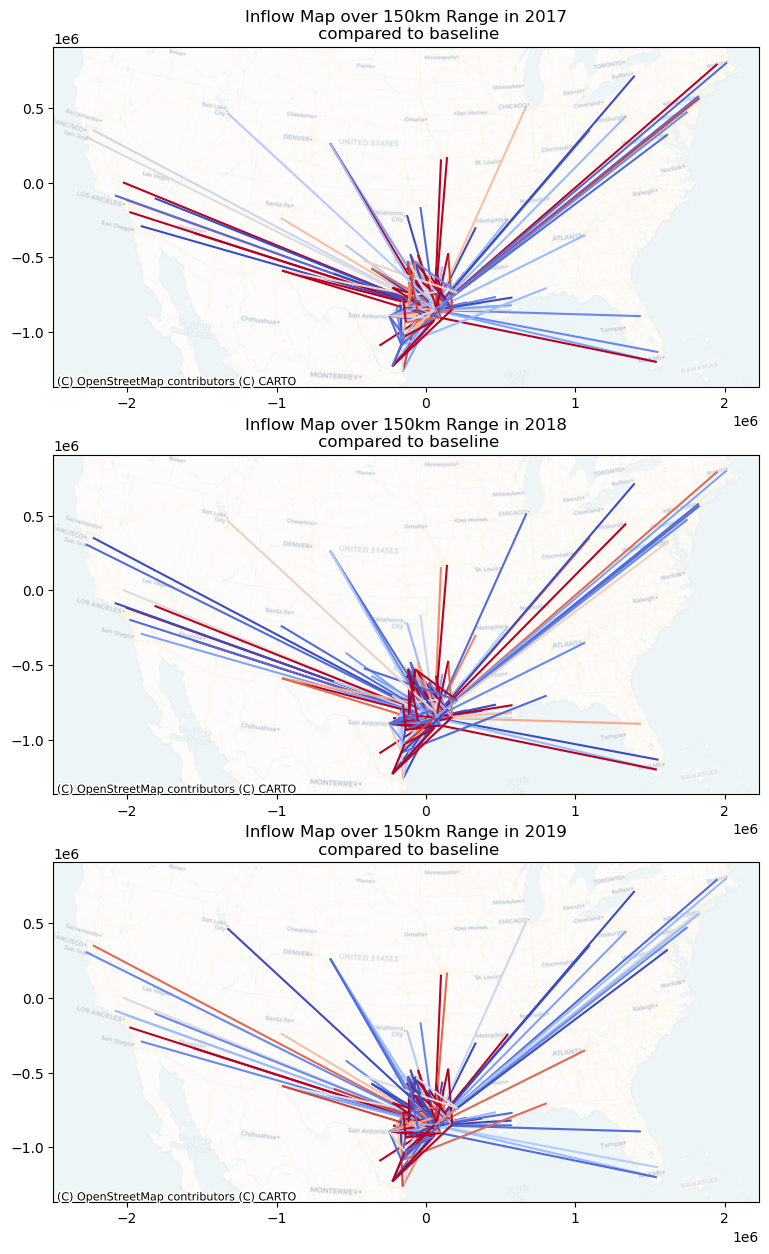

In [315]:
fig, axes = plt.subplots(3,1)
# for i in range(len(gdf_od_over150)):
#     x0 = gdf_od_over150[i:i+1]["x_o"]
#     x1 = gdf_od_over150[i:i+1]["x_d"]
#     y0 = gdf_od_over150[i:i+1]["y_o"]
#     y1 = gdf_od_over150[i:i+1]["y_d"]
#     xpos = (x0+x1)/2
#     ypos = (y0+y1)/2
#     xdir = x1-x0
#     ydir = y1-y0
#     for X,Y,dX,dY in zip(xpos, ypos, xdir, ydir):
#         axes[0].annotate("", xytext=(X,Y),xy=(X+0.001*dX,Y+0.001*dY), 
#         arrowprops=dict(arrowstyle="->", color='k'), size = 12)
#         axes[1].annotate("", xytext=(X,Y),xy=(X+0.001*dX,Y+0.001*dY), 
#         arrowprops=dict(arrowstyle="->", color='k'), size = 12)
#         axes[2].annotate("", xytext=(X,Y),xy=(X+0.001*dX,Y+0.001*dY), 
#         arrowprops=dict(arrowstyle="->", color='k'), size = 12)
gdf_od2_over150.plot(column='cr_prior_in',
     cmap='coolwarm',
     scheme='userdefined',classification_kwds={'bins':[ -75, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 75, 100]},
     alpha = 1,
     ax=axes[0])
cx.add_basemap(ax=axes[0],source=cx.providers.CartoDB.Voyager,crs=gdf_od.crs,alpha = 0.4)
axes[0].set_title("Inflow Map over 150km Range in 2017\n compared to baseline")
gdf_od2_over150.plot(column='cr_prior_post1',
     cmap='coolwarm',
     scheme='userdefined',classification_kwds={'bins':[ -75, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 75, 100]},
     alpha = 1,
     ax=axes[1])
cx.add_basemap(ax=axes[1],source=cx.providers.CartoDB.Voyager,crs=gdf_od.crs,alpha = 0.4)
axes[1].set_title("Inflow Map over 150km Range in 2018\n compared to baseline")
gdf_od2_over150.plot(column='cr_prior_post2',
     cmap='coolwarm',
     scheme='userdefined',classification_kwds={'bins':[ -75, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 75, 100]},
     alpha = 1,
     ax=axes[2])
cx.add_basemap(ax=axes[2],source=cx.providers.CartoDB.Voyager,crs=gdf_od.crs,alpha = 0.4)
axes[2].set_title("Inflow Map over 150km Range in 2019\n compared to baseline")